# Figure 1cd - GLMM fits for coexpression

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from pathlib import Path
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

In [2]:
sc.set_figure_params(dpi=100)

## Install required packages

In [3]:
#%pip install rpy2

In [4]:
# R integration
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, numpy2ri, r, Formula
from rpy2.robjects.vectors import StrVector, FloatVector, ListVector
import rpy2.robjects as ro
from rpy2.rinterface_lib.embedded import RRuntimeError

In [5]:
#!Rscript -e "install.packages('lme4', 'lmerTest', 'nloptr')"

In [ ]:
#%pip install plotnine -U

In [7]:
from plotnine import *

## Read datasets

In [8]:
genes = ['ACE2', 'TMPRSS2', 'CTSL']

In [9]:
datasets = {}

for f in tqdm(sorted(list(Path('data').glob('*.h5ad')))):
    ad = sc.read(f)
    
    if not np.all(np.isin(genes, ad.var_names)):
        continue

    f = f.stem

    assert ad.obs.dataset.nunique() == 1
    dataset = ad.obs.dataset[0]
    
    # filter cell types
    ad = ad[ad.obs.CellType != ''].copy()
    
    #print(dataset)
    #display(pd.crosstab(ad.obs.Sample_ID, ad.obs.Patient_ID))
    
    if dataset in [
        'Enteric Nervous System_Healthy_Regev/Xavier_unpublished',
        'Colon_Healthy_Regev/Xavier_2020',
        'Placenta_Healthy_Teichmann_2018',
        'Lung_Fibrosis_Xavier_snRNA-seq_unpublished',
        'Lung_Healthy_Xavier_snRNA-seq_unpublished',
        'Heart_Ventricle_Healthy_Ellinor_preprint 2020', 
        'Heart_Atrium_Healthy_Ellinor_preprint 2020',
    ]:
        ad.obs['Sample_ID'] = ad.obs['Patient_ID'].astype(str)

    print(dataset)    
    #print(sorted(ad.obs.Age.unique()))
    
    ad.X = scipy.sparse.csr_matrix(ad.X)
    ad.obs['nUMIs'] = ad.obs['nUMIs'].astype(int)
    x = ad.X.data[:10]
    
    if np.any(x != np.round(x)):
        x = scipy.sparse.csr_matrix(((ad.X.expm1().multiply(ad.obs.nUMIs.values[:, None]/10000.))))
        print(f'{f} NORMALIZED!')
        display(x.data[:10])
        x.data = np.round(x.data)
        ad.X = x
        
    ad.obs['log10_nUMIs'] = np.log10(ad.obs['nUMIs'])
    ad.obs['logACE2'] = np.log1p(ad.obs_vector('ACE2'))
    ad.obs['binACE2'] = (ad.obs_vector('ACE2')>0).astype(int)

    datasets[dataset] = ad
    
datasets = {k: datasets[k] for k in sorted(datasets)}

Placenta_Healthy_DennisLo_unpublished
Lung_Healthy_Nawijn_2019
Lung_Healthy_Misharin_unpublished
Lung_Healthy_Misharin/Budinger_2018
Lung_Healthy_Lafyatis/Rojas_2019
Placenta_Healthy_Rockefeller
Lung_Healthy_Meyer_2019
Placenta_Healthy_Teichmann_2018
Lung_Healthy_Kropski/Banovich_preprint 2019
Adipose_Healthy_Manton_unpublished
Heart_Atrium_Healthy_Ellinor_preprint 2020
Lung_Healthy_Barbry_preprint 2020
Nasal_Healthy_Barby_preprint 2020
Bone Marrow_Healthy_Regev_public
Brain_Healthy_Allen Atlas_public
Breast_Healthy_Regev_unpublished
Colon_Healthy_Regev/Xavier_2020
Cord Blood_Healthy_Regev_unpublished
Kidney_Healthy_Greka_unpublished
Enteric Nervous System_Healthy_Regev/Xavier_unpublished
Esophagus mucosa_Healthy_Regev_snRNA-seq_unpublished
Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished
Eye_Sanes_unpublished
Heart_Healthy_Harvard_unpublished
Heart_Healthy_Regev_snRNA-seq_unpublished
Lung_Non-smoker_Regev/Rajagopal_unpublished
Lung_Smoker_Regev/Rajagopal_unpublished
Liver_Heal

In [10]:
datasets

{'Adipose_Healthy_Manton_unpublished': AnnData object with n_obs × n_vars = 11167 × 27
     obs: 'original_cell_subset', 'CellType', 'Patient_ID', 'filename', 'dataset', 'nUMIs', 'Sample_ID', 'Gender', 'Age', 'barcodes', 'Count', 'log10_nUMIs', 'logACE2', 'binACE2'
     obsm: 'X_umap',
 'Bone Marrow_Healthy_Regev_public': AnnData object with n_obs × n_vars = 283894 × 27
     obs: 'original_cell_subset', 'CellType', 'Patient_ID', 'filename', 'dataset', 'nUMIs', 'Sample_ID', 'Gender', 'Age', 'barcodes', 'Count', 'log10_nUMIs', 'logACE2', 'binACE2'
     obsm: 'X_umap',
 'Brain_Healthy_Allen Atlas_public': AnnData object with n_obs × n_vars = 47509 × 27
     obs: 'original_cell_subset', 'CellType', 'Patient_ID', 'filename', 'dataset', 'nUMIs', 'Sample_ID', 'Gender', 'Age', 'barcodes', 'Count', 'log10_nUMIs', 'logACE2', 'binACE2'
     obsm: 'X_umap',
 'Breast_Healthy_Regev_unpublished': AnnData object with n_obs × n_vars = 17796 × 27
     obs: 'original_cell_subset', 'CellType', 'Patient_ID

In [11]:
len(datasets)

41

In [12]:
adata = sc.AnnData.concatenate(*datasets.values(), join='outer')
adata

AnnData object with n_obs × n_vars = 2795905 × 27
    obs: 'original_cell_subset', 'CellType', 'Patient_ID', 'filename', 'dataset', 'nUMIs', 'Sample_ID', 'Gender', 'Age', 'barcodes', 'Count', 'log10_nUMIs', 'logACE2', 'binACE2', 'batch'
    obsm: 'X_umap'

In [13]:
adata.obs['dataset_celltype'] = adata.obs.dataset.astype(str) + '-' + adata.obs.CellType.astype(str)

In [14]:
adata.X = adata.X / adata.obs['nUMIs'][:, None] * 10000

<ipython-input-14-22ca9bfa3988>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [15]:
sc.pp.log1p(adata)

In [16]:
def get_expressed(ad, genes, keys, thres=0, use_raw=False):
    genedf = sc.get.obs_df(ad, keys=[*keys, *genes], use_raw=use_raw)
    grouped = genedf.groupby(keys, observed=True)
    
    exp = grouped.agg(lambda x: np.nanmean(x[x>thres])).fillna(0)
    percent = grouped.agg(lambda x: np.mean(x>thres)*100).fillna(0)

    percent = percent.reset_index().melt(id_vars=keys, value_name='Percent exp.', var_name='gene')
    exp = exp.reset_index().melt(id_vars=keys, value_name='Mean expression', var_name='gene')
    df = percent.merge(exp)

    return df

In [ ]:
expr = get_expressed(adata, adata.var_names, keys=['dataset', 'CellType'])
expr = expr.sort_values('Percent exp.', ascending=False).reset_index(drop=True)

In [18]:
expr

dataset  \
0               Nasal_Healthy_Barby_preprint 2020   
1                        Lung_Healthy_Nawijn_2019   
2                         Lung_Healthy_Meyer_2019   
3               Nasal_Healthy_Barby_preprint 2020   
4                        Lung_Healthy_Nawijn_2019   
...                                           ...   
12496           Lung_Healthy_Barbry_preprint 2020   
12497           Lung_Healthy_Barbry_preprint 2020   
12498  Lung_Fibrosis_Xavier_snRNA-seq_unpublished   
12499  Lung_Fibrosis_Xavier_snRNA-seq_unpublished   
12500          Adipose_Healthy_Manton_unpublished   

                           CellType   gene  Percent exp.  Mean expression  
0                 Epithelial (Tuft)    MBP         100.0         1.056093  
1      Immune (Alveolar macrophage)   CTSB         100.0         2.445683  
2               Immune (Macrophage)   CTSB         100.0         2.230104  
3                 Epithelial (Tuft)  FURIN         100.0         1.890903  
4              Stromal (Fibroblast)    C1R         100.0         2.747601  
...                             ...    ...           ...              ...  
12496              Epithelial (AT2)    MAG           0.0         0.000000  
12497              Epithelial (AT1)    MAG           0.0         0.000000  
12498                 Stromal (SMC)    MAG           0.0         0.000000  
12499            Stromal (Pericyte)    MAG           0.0         0.000000  
12500                     Adipocyte   ACE2           0.0         0.000000  

[12501 rows x 5 columns]

In [19]:
expr.to_csv('supptable-X-percent-mean.csv', index=False)

In [20]:
expr.head()

dataset                      CellType   gene  \
0  Nasal_Healthy_Barby_preprint 2020             Epithelial (Tuft)    MBP   
1           Lung_Healthy_Nawijn_2019  Immune (Alveolar macrophage)   CTSB   
2            Lung_Healthy_Meyer_2019           Immune (Macrophage)   CTSB   
3  Nasal_Healthy_Barby_preprint 2020             Epithelial (Tuft)  FURIN   
4           Lung_Healthy_Nawijn_2019          Stromal (Fibroblast)    C1R   

   Percent exp.  Mean expression  
0         100.0         1.056093  
1         100.0         2.445683  
2         100.0         2.230104  
3         100.0         1.890903  
4         100.0         2.747601

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 26 x 12 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-X-ace2-percent-dotplot.pdf


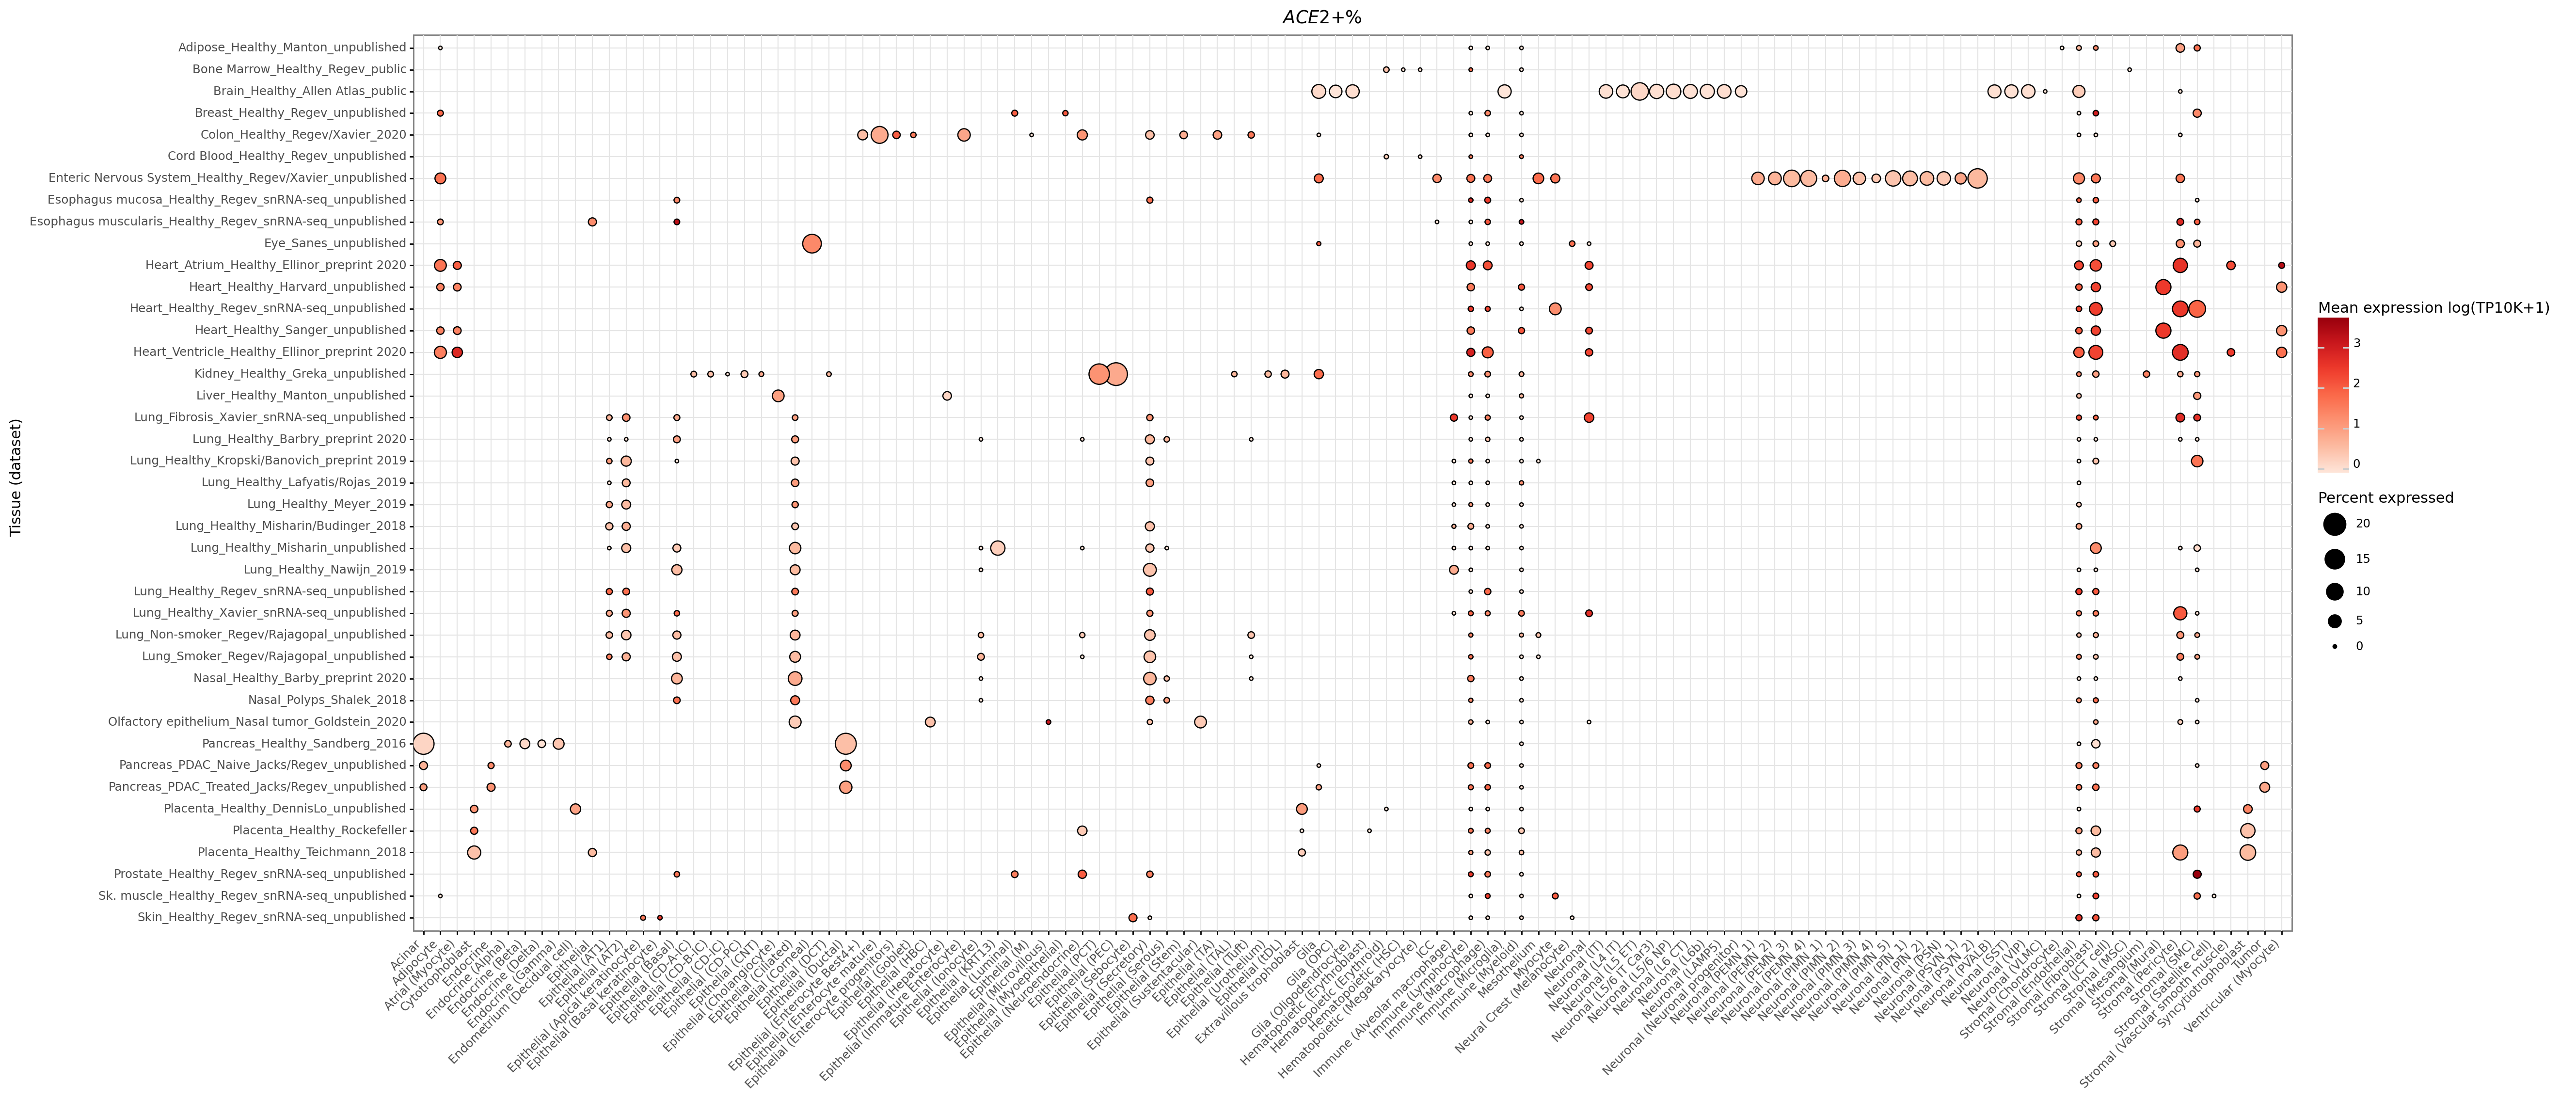

<ggplot: (8728605001460)>


In [21]:
df = expr[expr.gene == 'ACE2'].copy()
df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(datasets.keys())))


g = (
    ggplot(aes(x='CellType', y='dataset'), data=df) +
    geom_point(aes(size='Percent exp.', fill='Mean expression'))+
    scale_fill_distiller(type='seq', palette='Reds', name='Mean expression log(TP10K+1)', direction=1) + 
    labs(size = "Percent expressed", y='Tissue (dataset)', x='', title='$ACE2$+%') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,9)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
      figure_size=(25,12),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-X-ace2-percent-dotplot.pdf', width=26, height=12, limitsize=False)
print(g)

In [22]:
set([x.split('_')[0] for x in adata.obs.dataset])

{'Adipose',
 'Bone Marrow',
 'Brain',
 'Breast',
 'Colon',
 'Cord Blood',
 'Enteric Nervous System',
 'Esophagus mucosa',
 'Esophagus muscularis',
 'Eye',
 'Heart',
 'Kidney',
 'Liver',
 'Lung',
 'Nasal',
 'Olfactory epithelium',
 'Pancreas',
 'Placenta',
 'Prostate',
 'Sk. muscle',
 'Skin'}

## Fit models

In [23]:
def fit_lme(formula, df, family='gaussian', random_effect=True, **fit_kwargs):
    f = Formula(formula)
    
    lme4 = importr('lme4')
    lmer = importr('lmerTest') # overloads lmer function from lme4 package
    base = importr('base')
    stats = importr('stats')

    with localconverter(ro.default_converter + pandas2ri.converter):
        if family == 'gaussian':
            if random_effect:
                control = lme4.lmerControl(**{'calc.derivs': True,
                                              'check.rankX': 'silent.drop.cols', 
                                              'check.conv.singular': r('lme4::.makeCC')(action = "ignore",  tol = 1e-4)})
                fit = lmer.lmer(f, df, control=control, **fit_kwargs)
            else:
                fit = stats.lm(f, df, **fit_kwargs)
        elif family in ('binomial', 'poisson'):
            if random_effect:
                #control = lme4.glmerControl(**{'optimizer': 'nloptwrap', 
                #                               'calc.derivs': True,
                #                               'check.rankX': 'silent.drop.cols',
                #                               'check.conv.singular': r('lme4::.makeCC')(action = "ignore",  tol = 1e-4)})

                control = lme4.glmerControl(**{'check.rankX': 'silent.drop.cols',
                                               'check.conv.singular': r('lme4::.makeCC')(action = "ignore",  tol = 1e-4)})

                fit = lme4.glmer(f, df, control=control, family=family, **fit_kwargs)

            else:
                fit = stats.glm(f, df, family=family, **fit_kwargs)
        else:
            if random_effect:
                control = lme4.glmerControl(**{'optimizer': 'nloptwrap', 
                                   'calc.derivs': True,
                                   'check.rankX': 'silent.drop.cols',
                                   'check.conv.singular': r('lme4::.makeCC')(action = "ignore",  tol = 1e-4)})
                fit = r('lme4::glmer.nb')(f, df, **{'nb.control': control}, **fit_kwargs)
            else:
                fit = r('MASS::glm.nb')(f, df, **fit_kwargs)
        
        anova_df = stats.anova(fit)
    
    coef_df = r['as.data.frame'](stats.coef(base.summary(fit)))
    coef_df = pandas2ri.rpy2py(coef_df)

    return coef_df, anova_df

def _fit(formula, gene, adata, obs_features, use_raw, family, random_effect):
    gene_vec = adata[:, gene].X if not use_raw else adata.raw[:, gene].X
    covariates = adata.obs[obs_features].copy()
    covariates.loc[:, 'gene'] = gene_vec.A.squeeze()

    try:
        coefs, anova = fit_lme(formula, covariates, family=family, random_effect=random_effect)
    except RRuntimeError:
        print('Exception in R...')
        coefs, anova = None, None

    return coefs, anova


def fit_lme_adata(adata, genes, formula, obs_features, random_effect, family='gaussian', use_raw=False, n_jobs=4):

    adata = adata.copy()
    for f in obs_features:
        if adata.obs[f].dtype.name == 'category' and len(adata.obs[f].cat.categories) < 2:
            print(f'\tRemoving {f}... ({adata.obs[f].cat.categories.to_list()})')
            adata.obs[f] = adata.obs[f].cat.codes
            if f == random_effect:
                random_effect = False

    if n_jobs == 1:
        para_result = [_fit(formula, x, adata, obs_features, use_raw, family,random_effect) for x in (genes)]
    else:    
        para_result = Parallel(n_jobs=n_jobs)(delayed(_fit)(formula, 
                                                            x, 
                                                            adata,
                                                            obs_features, 
                                                            use_raw, 
                                                            family,
                                                            random_effect) for x in (genes))
    
    coef_df = {k:v[0] for k, v in zip(genes, para_result) if v[0] is not None}
    anova_df = {k:v[1] for k, v in zip(genes, para_result) if v[1] is not None}   

    coef_df = pd.concat([df.assign(gene=gene) for gene, df in coef_df.items()], axis=0)
    coef_df = coef_df.reset_index().rename(columns={'index': 'fixed_effect'})

    anova_df = pd.concat([df.assign(gene=gene) for gene, df in anova_df.items()], axis=0)
    anova_df = anova_df.reset_index().rename(columns={'index': 'fixed_effect'})
   
    return coef_df, anova_df


In [24]:
def fit_coexpression_model(adata, label, subsample_ref=True, n_jobs=20):

    adata = adata[adata.obs.CellType!=''].copy()
    adata.X = (adata.X>0).astype(int) # binarize for binomial GLMM

    res = []
    
    ct = (adata.obs.groupby('CellType').size() >= 5) & (adata.obs.groupby('CellType')['binACE2'].sum() >= 5)
    ct = ct[ct].index.to_list()
    
    if not ct:
        print(f'!!! Dataset {label} No available cell types...')
        return

    for celltype in tqdm(ct):
        ad = adata[(adata.obs.CellType == celltype)].copy()

        if subsample_ref:
            ad_pos = ad[ad.obs.binACE2 == 1]
            ad_neg = sc.pp.subsample(ad[ad.obs.binACE2 == 0], n_obs=len(ad_pos), copy=True)
            ad = ad_pos.concatenate(ad_neg)        
        
        genes = ad.var_names.difference(['ACE2']).to_list()
        genes = (len(ad) > sc.get.obs_df(ad, genes).sum(0)) & (sc.get.obs_df(ad, genes).sum(0) >= 5)
        genes = genes[genes].index.to_list()
        
        if len(genes) == 0:
            continue
            
        print(f'*** Dataset: {label:>60} Cell type: {celltype:>40} # genes: {len(genes):>5} # cells: {len(ad):>6} ***')
        ad.obs['Sample_ID'] = ad.obs['Sample_ID'].astype('category')
        
        coef, anova = fit_lme_adata(ad, 
                                    genes, 
                                    'gene ~ 1 + binACE2 + (1|Sample_ID)',
                                    ['binACE2', 'Sample_ID'],
                                    family='binomial',
                                    random_effect = 'Sample_ID',
                                    n_jobs=min(n_jobs, len(genes)))

        sig, pval, _, _ = multipletests(coef['Pr(>|z|)'], method='fdr_bh', alpha=0.1)
        coef['significant'] = sig
        coef['pval_adj'] = pval
        coef['neglog_pval_adj'] = -np.log10(coef.pval_adj+1e-300)
        res.append(coef.assign(celltype=celltype))
        
    if not res:
        return None

    res = pd.concat(res, axis=0)
    res = res[res.fixed_effect == 'binACE2'].sort_values('pval_adj').reset_index(drop=True).assign(dataset=label)
    
    return res

In [25]:
results = [fit_coexpression_model(v, k) for k,v in tqdm(datasets.items())]
results = pd.concat(results, axis=0).reset_index(drop=True)
results.head()

*** Dataset:                           Adipose_Healthy_Manton_unpublished Cell type:                       Stromal (Pericyte) # genes:     3 # cells:     12 ***



*** Dataset:                             Bone Marrow_Healthy_Regev_public Cell type:                Hematopoietic (Erythroid) # genes:     9 # cells:     68 ***



*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                                     Glia # genes:    23 # cells:    150 ***
*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                               Glia (OPC) # genes:    20 # cells:     74 ***
*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                   Glia (Oligodendrocyte) # genes:    23 # cells:    216 ***
*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                       Immune (Microglia) # genes:    21 # cells:     82 ***
*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                            Neuronal (IT) # genes:    26 # cells:   2566 ***
*** Dataset:                             Brain_Healthy_Allen Atlas_public Cell type:                         Neuronal (L4 IT) # genes:    24 # cells:    384 ***
*** Dataset:                      

*** Dataset:                             Breast_Healthy_Regev_unpublished Cell type:                                Adipocyte # genes:     1 # cells:     14 ***
*** Dataset:                             Breast_Healthy_Regev_unpublished Cell type:                     Epithelial (Luminal) # genes:     3 # cells:     52 ***
*** Dataset:                             Breast_Healthy_Regev_unpublished Cell type:                            Stromal (SMC) # genes:     5 # cells:     70 ***



*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:           Epithelial (Enterocyte Best4+) # genes:    15 # cells:     62 ***
*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:           Epithelial (Enterocyte mature) # genes:    14 # cells:    420 ***
*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:      Epithelial (Enterocyte progenitors) # genes:     6 # cells:     98 ***
*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:                      Epithelial (Goblet) # genes:     1 # cells:     12 ***
*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:         Epithelial (Immature Enterocyte) # genes:    16 # cells:    820 ***
*** Dataset:                              Colon_Healthy_Regev/Xavier_2020 Cell type:                   Epithelial (Secretory) # genes:    13 # cells:     88 ***
*** Dataset:                      

*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                                Adipocyte # genes:     7 # cells:     32 ***
*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                                     Glia # genes:    16 # cells:    204 ***
*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                                      ICC # genes:     9 # cells:     30 ***
*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                      Immune (Lymphocyte) # genes:     9 # cells:     44 ***
*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                      Immune (Macrophage) # genes:    17 # cells:    194 ***
*** Dataset:      Enteric Nervous System_Healthy_Regev/Xavier_unpublished Cell type:                              Mesothelium # genes:    13 # cells:     50 ***
*** Dataset:      Enteric Nervous 

*** Dataset:         Esophagus mucosa_Healthy_Regev_snRNA-seq_unpublished Cell type:                       Epithelial (Basal) # genes:    12 # cells:     90 ***
*** Dataset:         Esophagus mucosa_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:     4 # cells:     24 ***



*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                               Epithelial # genes:     6 # cells:     24 ***
*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                      Immune (Macrophage) # genes:     2 # cells:     10 ***
*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                    Stromal (Endothelial) # genes:     3 # cells:     36 ***
*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:     9 # cells:    116 ***
*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                       Stromal (Pericyte) # genes:     1 # cells:     14 ***
*** Dataset:     Esophagus muscularis_Healthy_Regev_snRNA-seq_unpublished Cell type:                            Stromal (SMC) # genes:     8 # cells:     56 ***



*** Dataset:                                        Eye_Sanes_unpublished Cell type:                     Epithelial (Corneal) # genes:    13 # cells:    192 ***
*** Dataset:                                        Eye_Sanes_unpublished Cell type:                            Stromal (SMC) # genes:     8 # cells:    116 ***



*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                                Adipocyte # genes:    15 # cells:    340 ***
*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                         Atrial (Myocyte) # genes:    17 # cells:    816 ***
*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                      Immune (Lymphocyte) # genes:     1 # cells:     24 ***
*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                      Immune (Macrophage) # genes:    14 # cells:    328 ***
*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                    Stromal (Endothelial) # genes:    16 # cells:    432 ***
*** Dataset:                   Heart_Atrium_Healthy_Ellinor_preprint 2020 Cell type:                     Stromal (Fibroblast) # genes:    20 # cells:   4130 ***
*** Dataset:                   Hea

*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                                Adipocyte # genes:     3 # cells:     28 ***
*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                         Atrial (Myocyte) # genes:    18 # cells:    338 ***
*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                      Immune (Lymphocyte) # genes:     5 # cells:     36 ***
*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                         Immune (Myeloid) # genes:    11 # cells:     66 ***
*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                                 Neuronal # genes:     3 # cells:     20 ***
*** Dataset:                            Heart_Healthy_Harvard_unpublished Cell type:                    Stromal (Endothelial) # genes:    13 # cells:    158 ***
*** Dataset:                      

*** Dataset:                    Heart_Healthy_Regev_snRNA-seq_unpublished Cell type:                      Immune (Macrophage) # genes:     2 # cells:     18 ***
*** Dataset:                    Heart_Healthy_Regev_snRNA-seq_unpublished Cell type:                                  Myocyte # genes:    20 # cells:    684 ***
*** Dataset:                    Heart_Healthy_Regev_snRNA-seq_unpublished Cell type:                    Stromal (Endothelial) # genes:     3 # cells:     42 ***
*** Dataset:                    Heart_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:    18 # cells:   1066 ***
*** Dataset:                    Heart_Healthy_Regev_snRNA-seq_unpublished Cell type:                       Stromal (Pericyte) # genes:    16 # cells:    548 ***



*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                                Adipocyte # genes:     3 # cells:     28 ***
*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                         Atrial (Myocyte) # genes:    18 # cells:    338 ***
*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                      Immune (Lymphocyte) # genes:     5 # cells:     36 ***
*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                         Immune (Myeloid) # genes:    11 # cells:     66 ***
*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                                 Neuronal # genes:     3 # cells:     20 ***
*** Dataset:                             Heart_Healthy_Sanger_unpublished Cell type:                    Stromal (Endothelial) # genes:    13 # cells:    158 ***
*** Dataset:                      

*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                                Adipocyte # genes:    16 # cells:    382 ***
*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                      Immune (Macrophage) # genes:    15 # cells:    482 ***
*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                    Stromal (Endothelial) # genes:    17 # cells:    786 ***
*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                     Stromal (Fibroblast) # genes:    20 # cells:   3338 ***
*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                       Stromal (Pericyte) # genes:    18 # cells:   1814 ***
*** Dataset:                Heart_Ventricle_Healthy_Ellinor_preprint 2020 Cell type:                    Ventricular (Myocyte) # genes:    19 # cells:   3078 ***



*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                     Epithelial (CD-B-IC) # genes:     8 # cells:     10 ***
*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                       Epithelial (CD-PC) # genes:    12 # cells:     40 ***
*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                         Epithelial (PCT) # genes:    19 # cells:   1888 ***
*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                         Epithelial (PEC) # genes:    20 # cells:    474 ***
*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                         Epithelial (TAL) # genes:     7 # cells:     14 ***
*** Dataset:                             Kidney_Healthy_Greka_unpublished Cell type:                  Epithelial (Urothelium) # genes:    12 # cells:     54 ***
*** Dataset:                      

*** Dataset:                             Liver_Healthy_Manton_unpublished Cell type:               Epithelial (Cholangiocyte) # genes:    14 # cells:     34 ***



*** Dataset:                   Lung_Fibrosis_Xavier_snRNA-seq_unpublished Cell type:                         Epithelial (AT2) # genes:    16 # cells:     50 ***
*** Dataset:                   Lung_Fibrosis_Xavier_snRNA-seq_unpublished Cell type:                    Epithelial (Ciliated) # genes:     2 # cells:     14 ***
*** Dataset:                   Lung_Fibrosis_Xavier_snRNA-seq_unpublished Cell type:                   Epithelial (Secretory) # genes:     7 # cells:     22 ***



*** Dataset:                            Lung_Healthy_Barbry_preprint 2020 Cell type:                       Epithelial (Basal) # genes:    15 # cells:    414 ***
*** Dataset:                            Lung_Healthy_Barbry_preprint 2020 Cell type:                    Epithelial (Ciliated) # genes:    12 # cells:    120 ***
*** Dataset:                            Lung_Healthy_Barbry_preprint 2020 Cell type:                   Epithelial (Secretory) # genes:    15 # cells:    320 ***



*** Dataset:                  Lung_Healthy_Kropski/Banovich_preprint 2019 Cell type:                         Epithelial (AT2) # genes:    19 # cells:    246 ***
*** Dataset:                  Lung_Healthy_Kropski/Banovich_preprint 2019 Cell type:                    Epithelial (Ciliated) # genes:    13 # cells:     50 ***
*** Dataset:                  Lung_Healthy_Kropski/Banovich_preprint 2019 Cell type:                   Epithelial (Secretory) # genes:     6 # cells:     14 ***
*** Dataset:                  Lung_Healthy_Kropski/Banovich_preprint 2019 Cell type:                            Stromal (SMC) # genes:     3 # cells:     14 ***



*** Dataset:                             Lung_Healthy_Lafyatis/Rojas_2019 Cell type:                         Epithelial (AT2) # genes:    12 # cells:     22 ***
*** Dataset:                             Lung_Healthy_Lafyatis/Rojas_2019 Cell type:                    Epithelial (Ciliated) # genes:     2 # cells:     10 ***



*** Dataset:                                      Lung_Healthy_Meyer_2019 Cell type:                         Epithelial (AT2) # genes:    20 # cells:    158 ***



*** Dataset:                          Lung_Healthy_Misharin/Budinger_2018 Cell type:                         Epithelial (AT1) # genes:    16 # cells:     24 ***
*** Dataset:                          Lung_Healthy_Misharin/Budinger_2018 Cell type:                         Epithelial (AT2) # genes:    20 # cells:    470 ***
*** Dataset:                          Lung_Healthy_Misharin/Budinger_2018 Cell type:                   Epithelial (Secretory) # genes:    10 # cells:     14 ***



*** Dataset:                            Lung_Healthy_Misharin_unpublished Cell type:                         Epithelial (AT2) # genes:    19 # cells:    144 ***
	Removing Sample_ID... (['SC85'])
*** Dataset:                            Lung_Healthy_Misharin_unpublished Cell type:                       Epithelial (Basal) # genes:    14 # cells:     48 ***
	Removing Sample_ID... (['SC88'])
*** Dataset:                            Lung_Healthy_Misharin_unpublished Cell type:                    Epithelial (Ciliated) # genes:    16 # cells:    174 ***
*** Dataset:                            Lung_Healthy_Misharin_unpublished Cell type:                       Epithelial (KRT13) # genes:     8 # cells:     14 ***
	Removing Sample_ID... (['SC88'])
*** Dataset:                            Lung_Healthy_Misharin_unpublished Cell type:                   Epithelial (Secretory) # genes:    14 # cells:     42 ***



*** Dataset:                                     Lung_Healthy_Nawijn_2019 Cell type:                       Epithelial (Basal) # genes:    19 # cells:    296 ***
*** Dataset:                                     Lung_Healthy_Nawijn_2019 Cell type:                    Epithelial (Ciliated) # genes:    12 # cells:     96 ***
*** Dataset:                                     Lung_Healthy_Nawijn_2019 Cell type:                   Epithelial (Secretory) # genes:    20 # cells:    230 ***



*** Dataset:                     Lung_Healthy_Regev_snRNA-seq_unpublished Cell type:                         Epithelial (AT1) # genes:     9 # cells:     62 ***
*** Dataset:                     Lung_Healthy_Regev_snRNA-seq_unpublished Cell type:                         Epithelial (AT2) # genes:    20 # cells:    230 ***
*** Dataset:                     Lung_Healthy_Regev_snRNA-seq_unpublished Cell type:                      Immune (Macrophage) # genes:    11 # cells:     68 ***
*** Dataset:                     Lung_Healthy_Regev_snRNA-seq_unpublished Cell type:                    Stromal (Endothelial) # genes:     1 # cells:     30 ***
*** Dataset:                     Lung_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:     2 # cells:     18 ***



*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                         Epithelial (AT1) # genes:     6 # cells:     10 ***
*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                         Epithelial (AT2) # genes:    17 # cells:     92 ***
*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                    Epithelial (Ciliated) # genes:     5 # cells:     22 ***
*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                   Epithelial (Secretory) # genes:     9 # cells:     18 ***
*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                    Stromal (Endothelial) # genes:     2 # cells:     18 ***
*** Dataset:                    Lung_Healthy_Xavier_snRNA-seq_unpublished Cell type:                       Stromal (Pericyte) # genes:     3 # cells:     34 ***



*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                         Epithelial (AT1) # genes:    19 # cells:    136 ***
*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                         Epithelial (AT2) # genes:    22 # cells:   1204 ***
*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                       Epithelial (Basal) # genes:    20 # cells:   1844 ***
*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                    Epithelial (Ciliated) # genes:    21 # cells:    642 ***
*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                   Epithelial (Secretory) # genes:    21 # cells:   1508 ***
*** Dataset:                  Lung_Non-smoker_Regev/Rajagopal_unpublished Cell type:                        Epithelial (Tuft) # genes:     2 # cells:     10 ***
*** Dataset:                  Lung

*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                         Epithelial (AT1) # genes:     7 # cells:     24 ***
*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                         Epithelial (AT2) # genes:    21 # cells:    780 ***
*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                       Epithelial (Basal) # genes:    20 # cells:    736 ***
*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                    Epithelial (Ciliated) # genes:    13 # cells:     78 ***
*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                   Epithelial (Secretory) # genes:    21 # cells:    616 ***
*** Dataset:                      Lung_Smoker_Regev/Rajagopal_unpublished Cell type:                       Stromal (Pericyte) # genes:     4 # cells:     10 ***



*** Dataset:                            Nasal_Healthy_Barby_preprint 2020 Cell type:                       Epithelial (Basal) # genes:    18 # cells:    320 ***
*** Dataset:                            Nasal_Healthy_Barby_preprint 2020 Cell type:                    Epithelial (Ciliated) # genes:    16 # cells:    152 ***
*** Dataset:                            Nasal_Healthy_Barby_preprint 2020 Cell type:                   Epithelial (Secretory) # genes:    19 # cells:    866 ***



*** Dataset:                                     Nasal_Polyps_Shalek_2018 Cell type:                       Epithelial (Basal) # genes:     7 # cells:     64 ***
*** Dataset:                                     Nasal_Polyps_Shalek_2018 Cell type:                    Epithelial (Ciliated) # genes:     3 # cells:     18 ***
*** Dataset:                                     Nasal_Polyps_Shalek_2018 Cell type:                   Epithelial (Secretory) # genes:     8 # cells:     50 ***
*** Dataset:                                     Nasal_Polyps_Shalek_2018 Cell type:                      Epithelial (Serous) # genes:     2 # cells:     10 ***



*** Dataset:              Olfactory epithelium_Nasal tumor_Goldstein_2020 Cell type:                    Epithelial (Ciliated) # genes:    14 # cells:     70 ***
*** Dataset:              Olfactory epithelium_Nasal tumor_Goldstein_2020 Cell type:                         Epithelial (HBC) # genes:    14 # cells:    108 ***
*** Dataset:              Olfactory epithelium_Nasal tumor_Goldstein_2020 Cell type:                   Epithelial (Secretory) # genes:     4 # cells:     12 ***
*** Dataset:              Olfactory epithelium_Nasal tumor_Goldstein_2020 Cell type:               Epithelial (Sustentacular) # genes:    17 # cells:    180 ***



*** Dataset:                               Pancreas_Healthy_Sandberg_2016 Cell type:                                   Acinar # genes:    22 # cells:     76 ***
*** Dataset:                               Pancreas_Healthy_Sandberg_2016 Cell type:                        Endocrine (Alpha) # genes:     8 # cells:     12 ***
*** Dataset:                               Pancreas_Healthy_Sandberg_2016 Cell type:                         Endocrine (Beta) # genes:     6 # cells:     12 ***
*** Dataset:                               Pancreas_Healthy_Sandberg_2016 Cell type:                        Endocrine (Gamma) # genes:     8 # cells:     16 ***
*** Dataset:                               Pancreas_Healthy_Sandberg_2016 Cell type:                      Epithelial (Ductal) # genes:    22 # cells:    176 ***



*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                                Endocrine # genes:     4 # cells:     18 ***
*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                      Epithelial (Ductal) # genes:    22 # cells:    482 ***
*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                      Immune (Lymphocyte) # genes:     4 # cells:     22 ***
*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                      Immune (Macrophage) # genes:     8 # cells:     28 ***
*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                    Stromal (Endothelial) # genes:     5 # cells:     34 ***
*** Dataset:                  Pancreas_PDAC_Naive_Jacks/Regev_unpublished Cell type:                     Stromal (Fibroblast) # genes:    17 # cells:    130 ***
*** Dataset:                  Panc

*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                                   Acinar # genes:     9 # cells:     28 ***
*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                                Endocrine # genes:    19 # cells:    138 ***
*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                      Epithelial (Ductal) # genes:    23 # cells:   1314 ***
*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                      Immune (Macrophage) # genes:     4 # cells:     14 ***
*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                    Stromal (Endothelial) # genes:     4 # cells:     22 ***
*** Dataset:                Pancreas_PDAC_Treated_Jacks/Regev_unpublished Cell type:                     Stromal (Fibroblast) # genes:    16 # cells:    200 ***
*** Dataset:                Pancre

*** Dataset:                        Placenta_Healthy_DennisLo_unpublished Cell type:                          Cytotrophoblast # genes:     5 # cells:     46 ***
	Removing Sample_ID... (['DennisLo'])
*** Dataset:                        Placenta_Healthy_DennisLo_unpublished Cell type:              Endometrium (Decidual cell) # genes:    12 # cells:     60 ***
	Removing Sample_ID... (['DennisLo'])
*** Dataset:                        Placenta_Healthy_DennisLo_unpublished Cell type:                 Extravillous trophoblast # genes:    12 # cells:    264 ***
	Removing Sample_ID... (['DennisLo'])
*** Dataset:                        Placenta_Healthy_DennisLo_unpublished Cell type:                      Syncytiotrophoblast # genes:     3 # cells:     18 ***
	Removing Sample_ID... (['DennisLo'])



*** Dataset:                                 Placenta_Healthy_Rockefeller Cell type:                          Cytotrophoblast # genes:     4 # cells:     28 ***
*** Dataset:                                 Placenta_Healthy_Rockefeller Cell type:                    Stromal (Endothelial) # genes:     4 # cells:     12 ***
*** Dataset:                                 Placenta_Healthy_Rockefeller Cell type:                     Stromal (Fibroblast) # genes:    17 # cells:    268 ***
*** Dataset:                                 Placenta_Healthy_Rockefeller Cell type:                      Syncytiotrophoblast # genes:    10 # cells:    146 ***



*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                          Cytotrophoblast # genes:    17 # cells:    996 ***
*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                               Epithelial # genes:     4 # cells:     10 ***
*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                 Extravillous trophoblast # genes:     9 # cells:     44 ***
*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                      Immune (Lymphocyte) # genes:     3 # cells:     10 ***
*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                      Immune (Macrophage) # genes:    11 # cells:     28 ***
*** Dataset:                              Placenta_Healthy_Teichmann_2018 Cell type:                     Stromal (Fibroblast) # genes:    20 # cells:    550 ***
*** Dataset:                      

*** Dataset:                 Prostate_Healthy_Regev_snRNA-seq_unpublished Cell type:                       Epithelial (Basal) # genes:     8 # cells:     42 ***
*** Dataset:                 Prostate_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Epithelial (Luminal) # genes:    13 # cells:    160 ***
*** Dataset:                 Prostate_Healthy_Regev_snRNA-seq_unpublished Cell type:                   Epithelial (Secretory) # genes:     6 # cells:     38 ***
*** Dataset:                 Prostate_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:     4 # cells:     22 ***



*** Dataset:               Sk. muscle_Healthy_Regev_snRNA-seq_unpublished Cell type:                                  Myocyte # genes:     8 # cells:    148 ***
*** Dataset:               Sk. muscle_Healthy_Regev_snRNA-seq_unpublished Cell type:                     Stromal (Fibroblast) # genes:     6 # cells:     38 ***



fixed_effect  Estimate  Std. Error   z value  Pr(>|z|)   gene  significant  \
0      binACE2  1.386294    1.224745  1.131905  0.257675   CTSL        False   
1      binACE2  1.560609    1.850803  0.843207  0.399113  FURIN        False   
2      binACE2 -1.386294    1.224745 -1.131904  0.257675  IL6ST        False   
3      binACE2  1.658228    0.566071  2.929362  0.003397   CTSC         True   
4      binACE2  0.664976    0.522053  1.273772  0.202744    MBP        False   

   pval_adj  neglog_pval_adj                   celltype  \
0  0.505293         0.296457         Stromal (Pericyte)   
1  0.505293         0.296457         Stromal (Pericyte)   
2  0.505293         0.296457         Stromal (Pericyte)   
3  0.012228         1.912655  Hematopoietic (Erythroid)   
4  0.456175         0.340869  Hematopoietic (Erythroid)   

                              dataset  
0  Adipose_Healthy_Manton_unpublished  
1  Adipose_Healthy_Manton_unpublished  
2  Adipose_Healthy_Manton_unpublished  
3    Bone Marrow_Healthy_Regev_public  
4    Bone Marrow_Healthy_Regev_public

In [26]:
results.to_csv('coexpression-results-subsampling.csv', index=False)

In [27]:
results = pd.read_csv('coexpression-results-subsampling.csv')

In [28]:
results['dataset'] = pd.Categorical(results['dataset'], categories=sorted(datasets.keys()))

## Plotting

### TMPRSS2

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 9 x 12 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-1-c.pdf


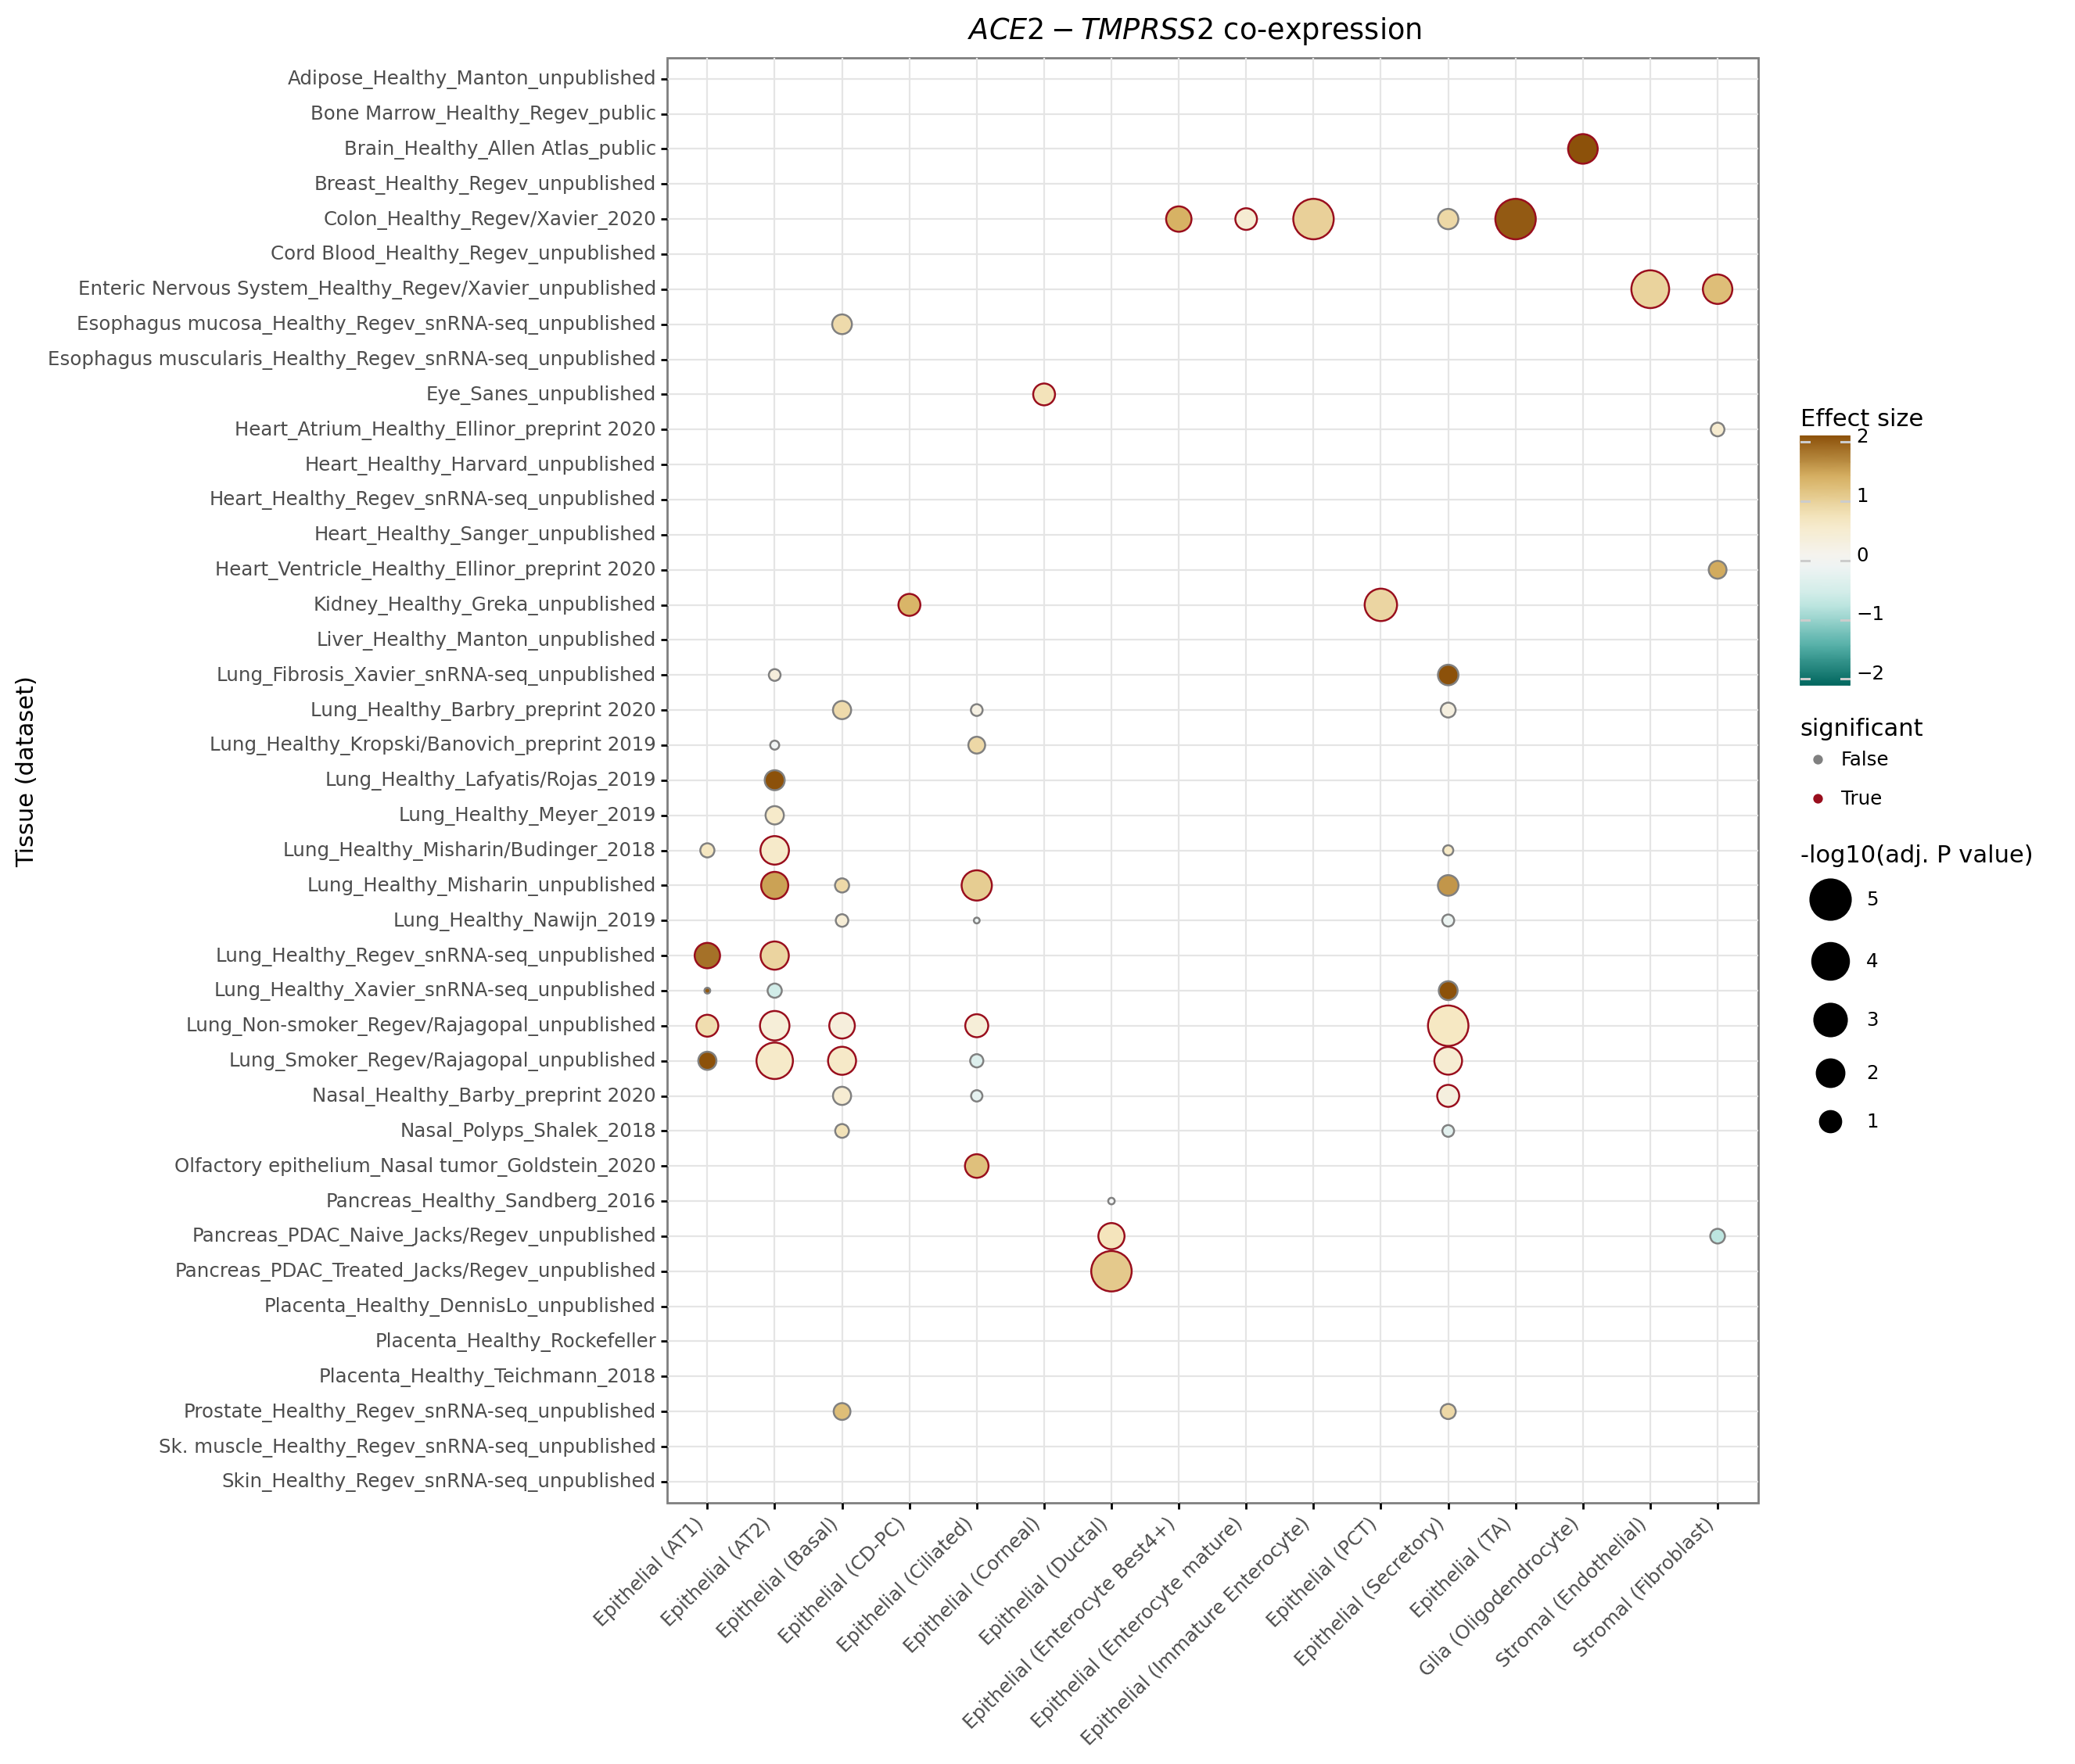

<ggplot: (8728565609421)>


In [29]:
df = results[results.gene == 'TMPRSS2'].copy()
df = df[~df.celltype.isin(['None', 'Tumor'])]

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

#df['celltype'] = pd.Categorical(df.celltype, categories = reversed(sorted(df.celltype.unique())))
df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(datasets.keys())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='celltype', y='dataset'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Tissue (dataset)', x='', title='$ACE2-TMPRSS2$ co-expression') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
      figure_size=(9,12),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-1-c.pdf', width=9, height=12)
print(g)

### CTSL

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 9 x 12 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-1-d.pdf


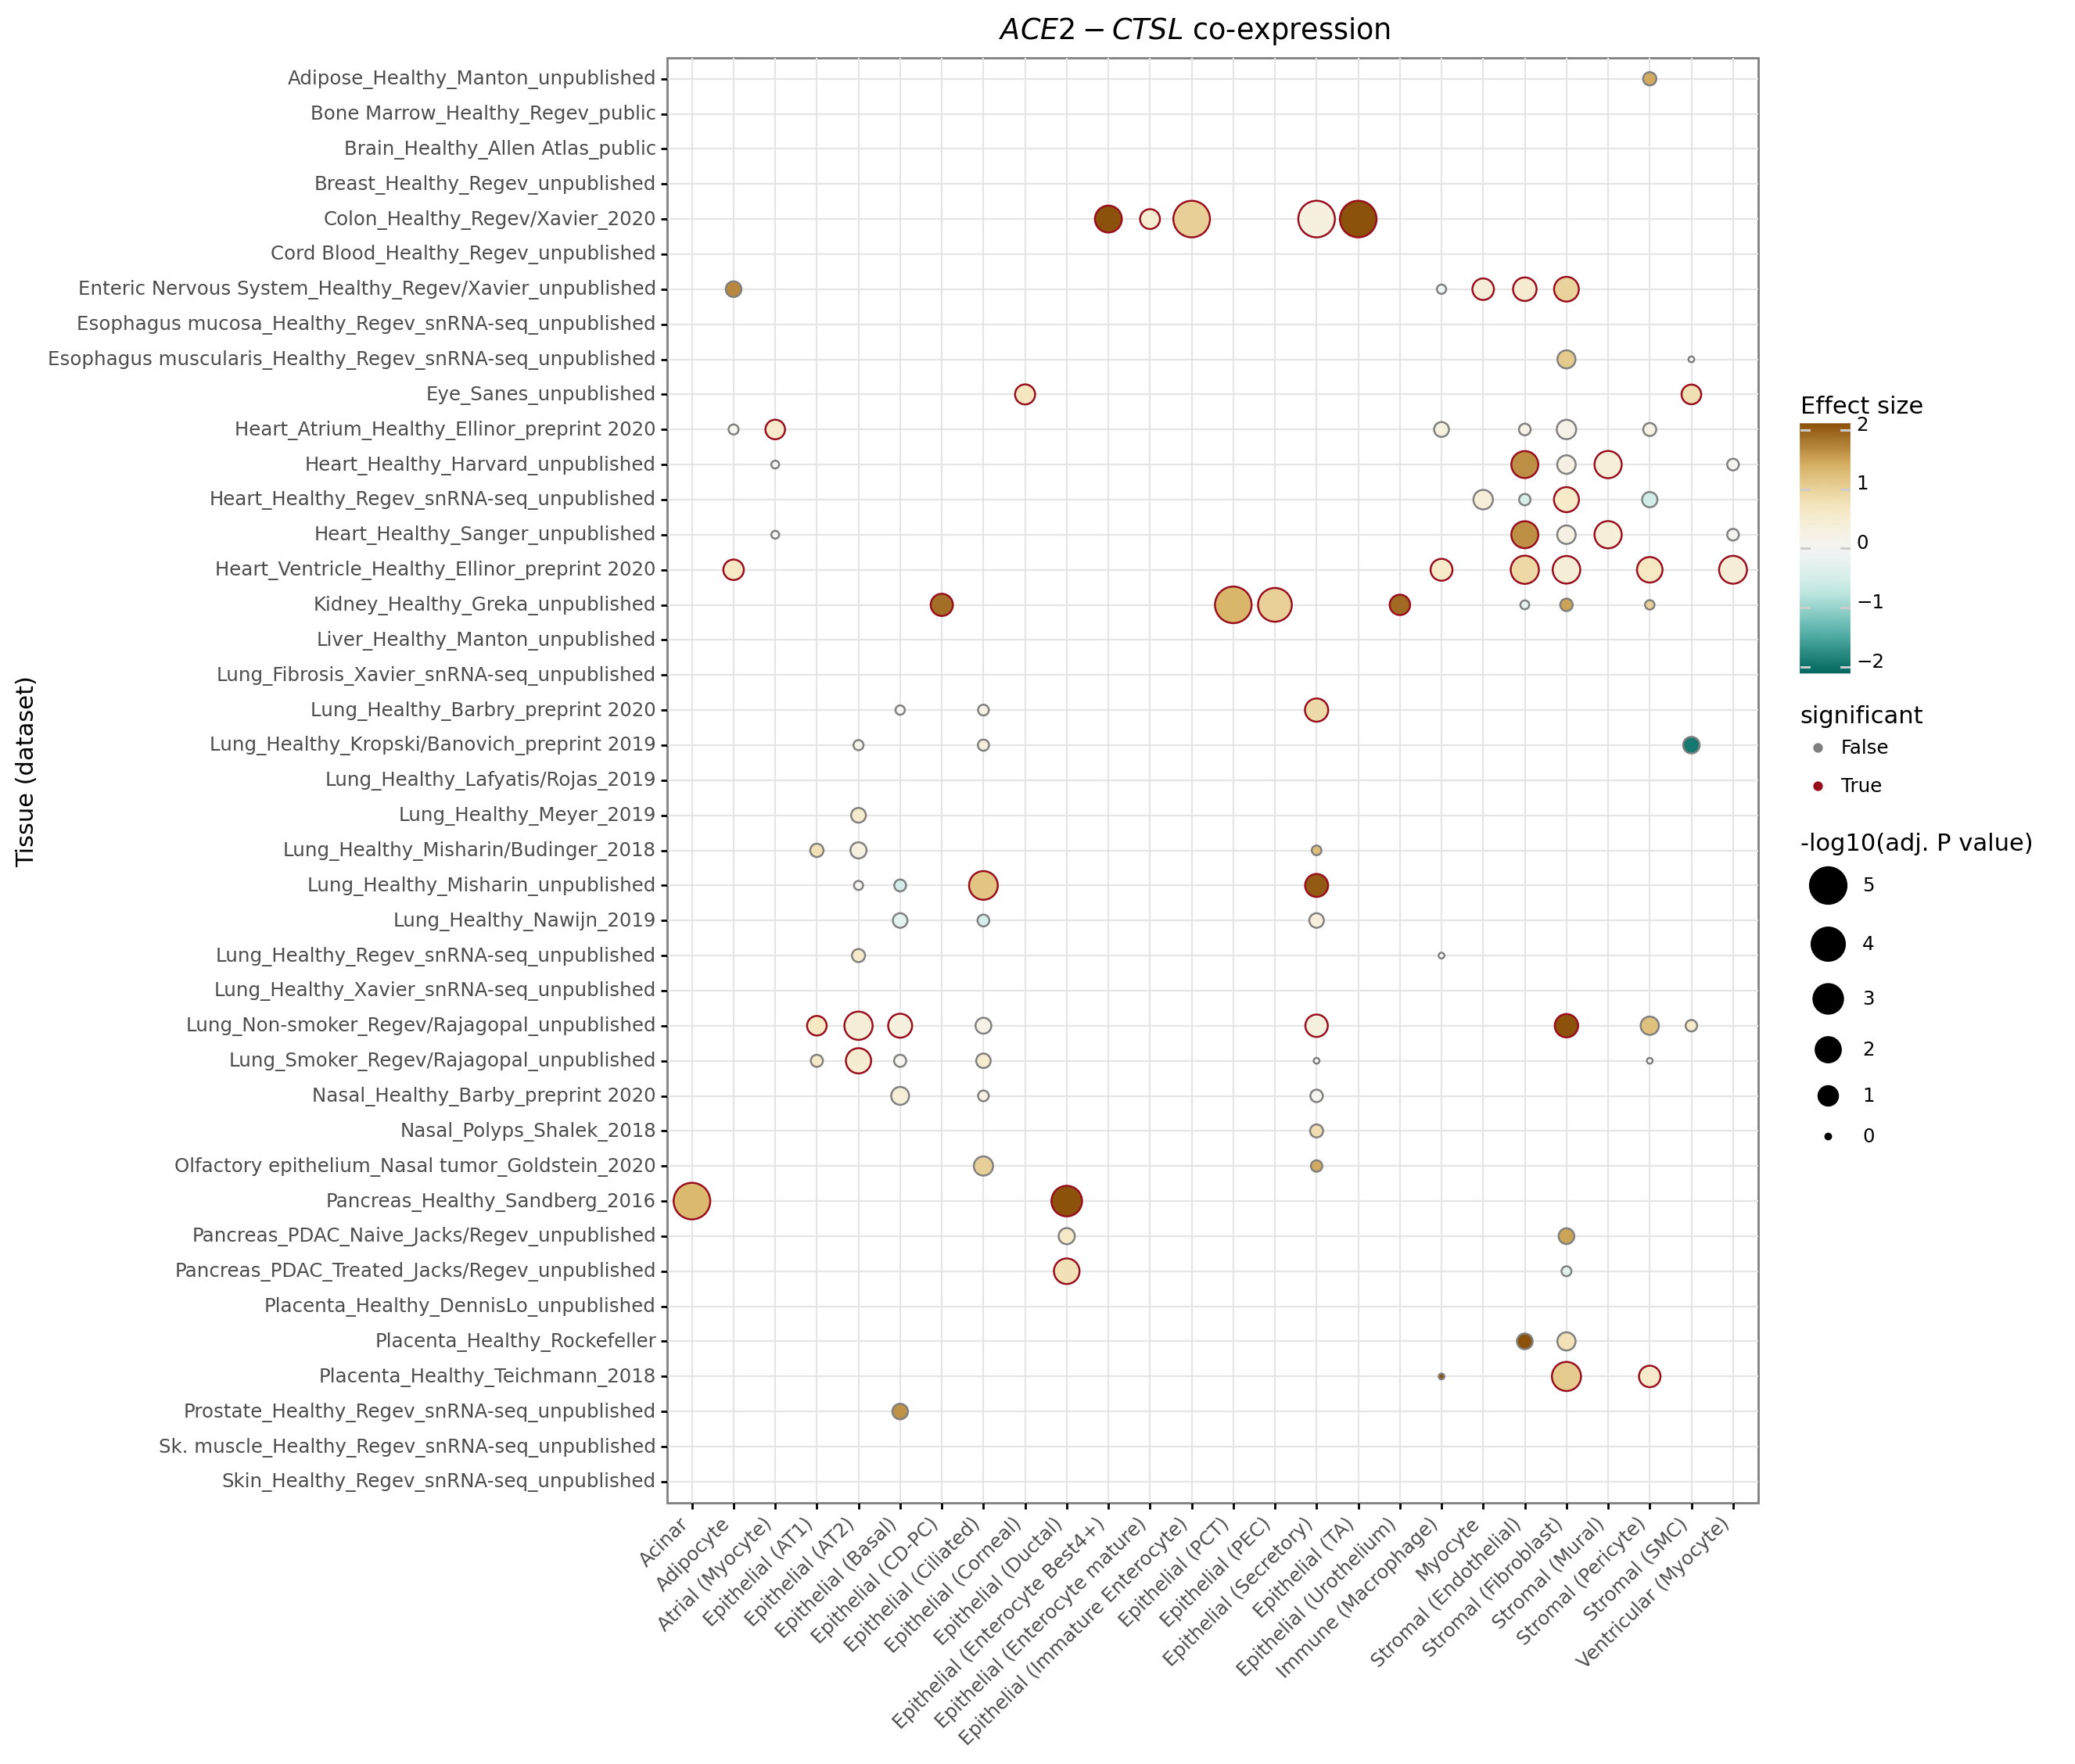

<ggplot: (8728573111342)>


In [30]:
df = results[results.gene == 'CTSL'].copy()
df = df[~df.celltype.isin(['None', 'Tumor'])]

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

#df['celltype'] = pd.Categorical(df.celltype, categories = reversed(sorted(df.celltype.unique())))
df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(datasets.keys())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='celltype', y='dataset'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Tissue (dataset)', x='', title='$ACE2-CTSL$ co-expression') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,9))+
    scale_y_discrete(drop=False) +
    theme(
      figure_size=(9,12),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-1-d.pdf', width=9, height=12)
print(g)

### Plot lung datasets

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 20 x 15 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-all-lung.pdf


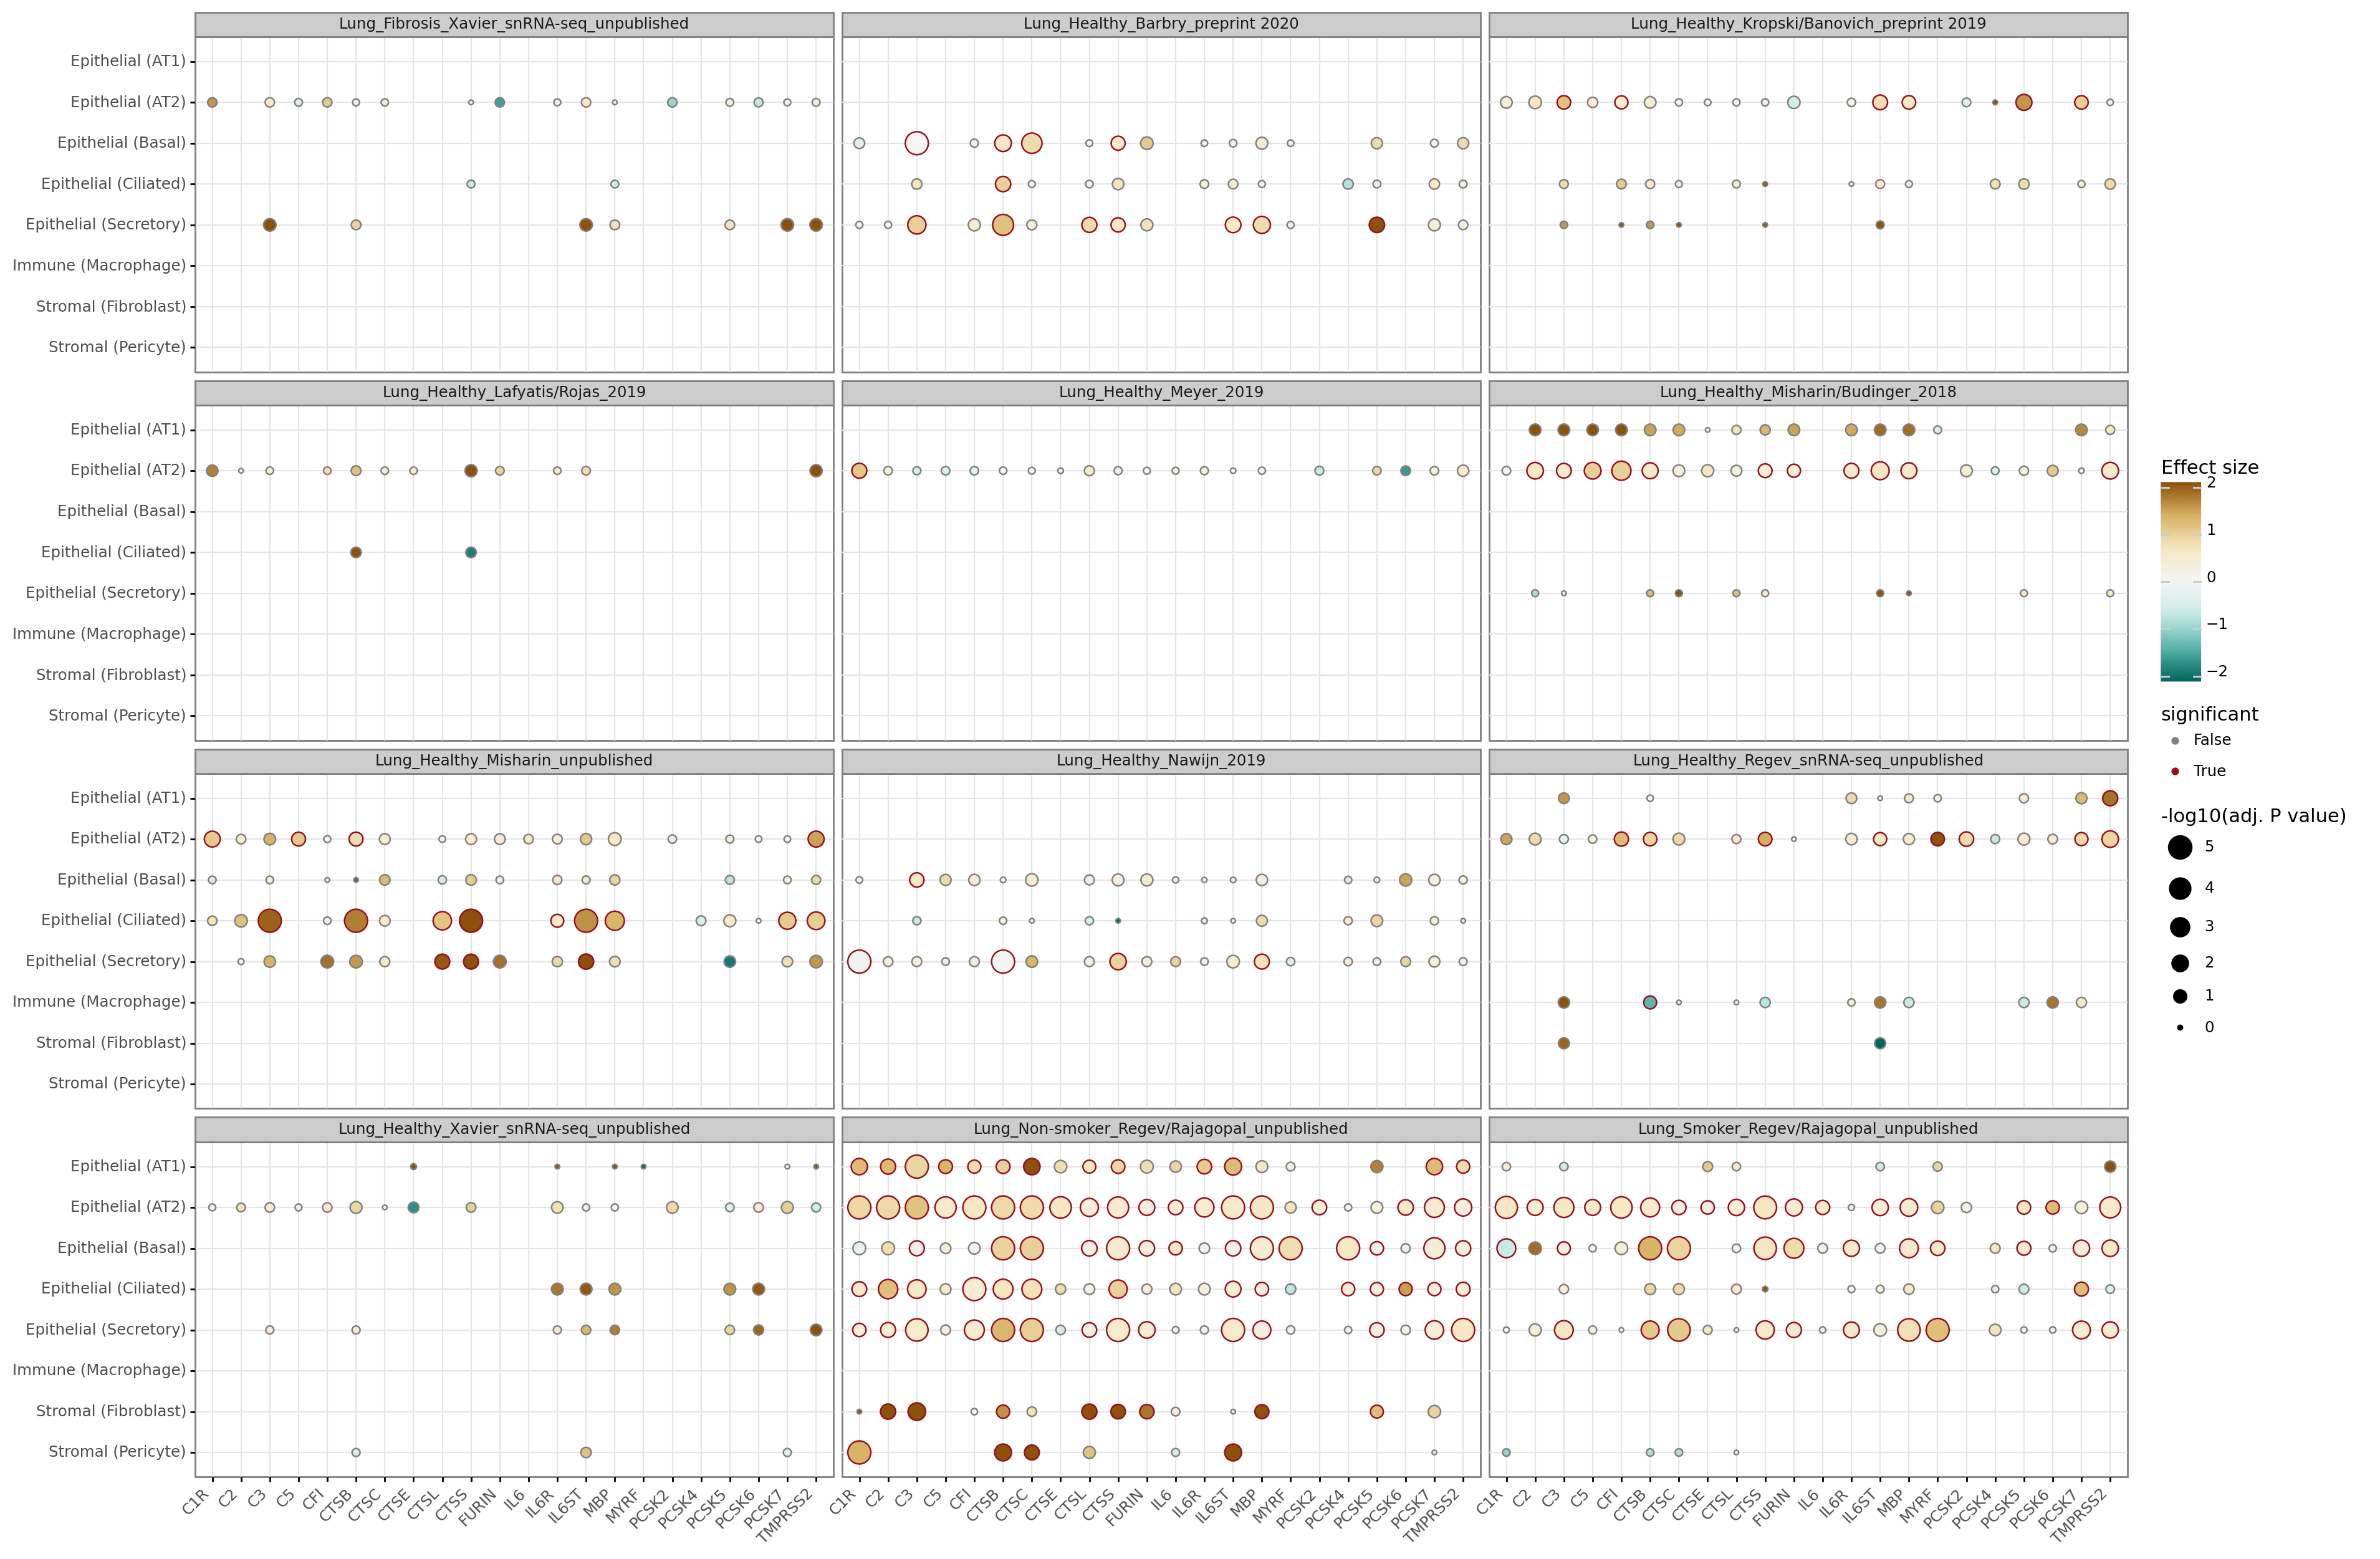

<ggplot: (8728567269331)>


In [31]:
df = results[results.dataset.str.contains('Lung')].copy()

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

df['celltype'] = pd.Categorical(df.celltype, categories = reversed(sorted(df.celltype.unique())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='gene', y='celltype'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Tissue (dataset)', x='') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,7))+
    facet_wrap('dataset', ncol=3)+
    theme(
      axis_title_x = element_blank(),
      axis_title_y = element_blank(),
      figure_size=(20,15),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-all-lung.pdf', width=20, height=15)
print(g)

## IL6

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 30 x 9 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-IL6.pdf


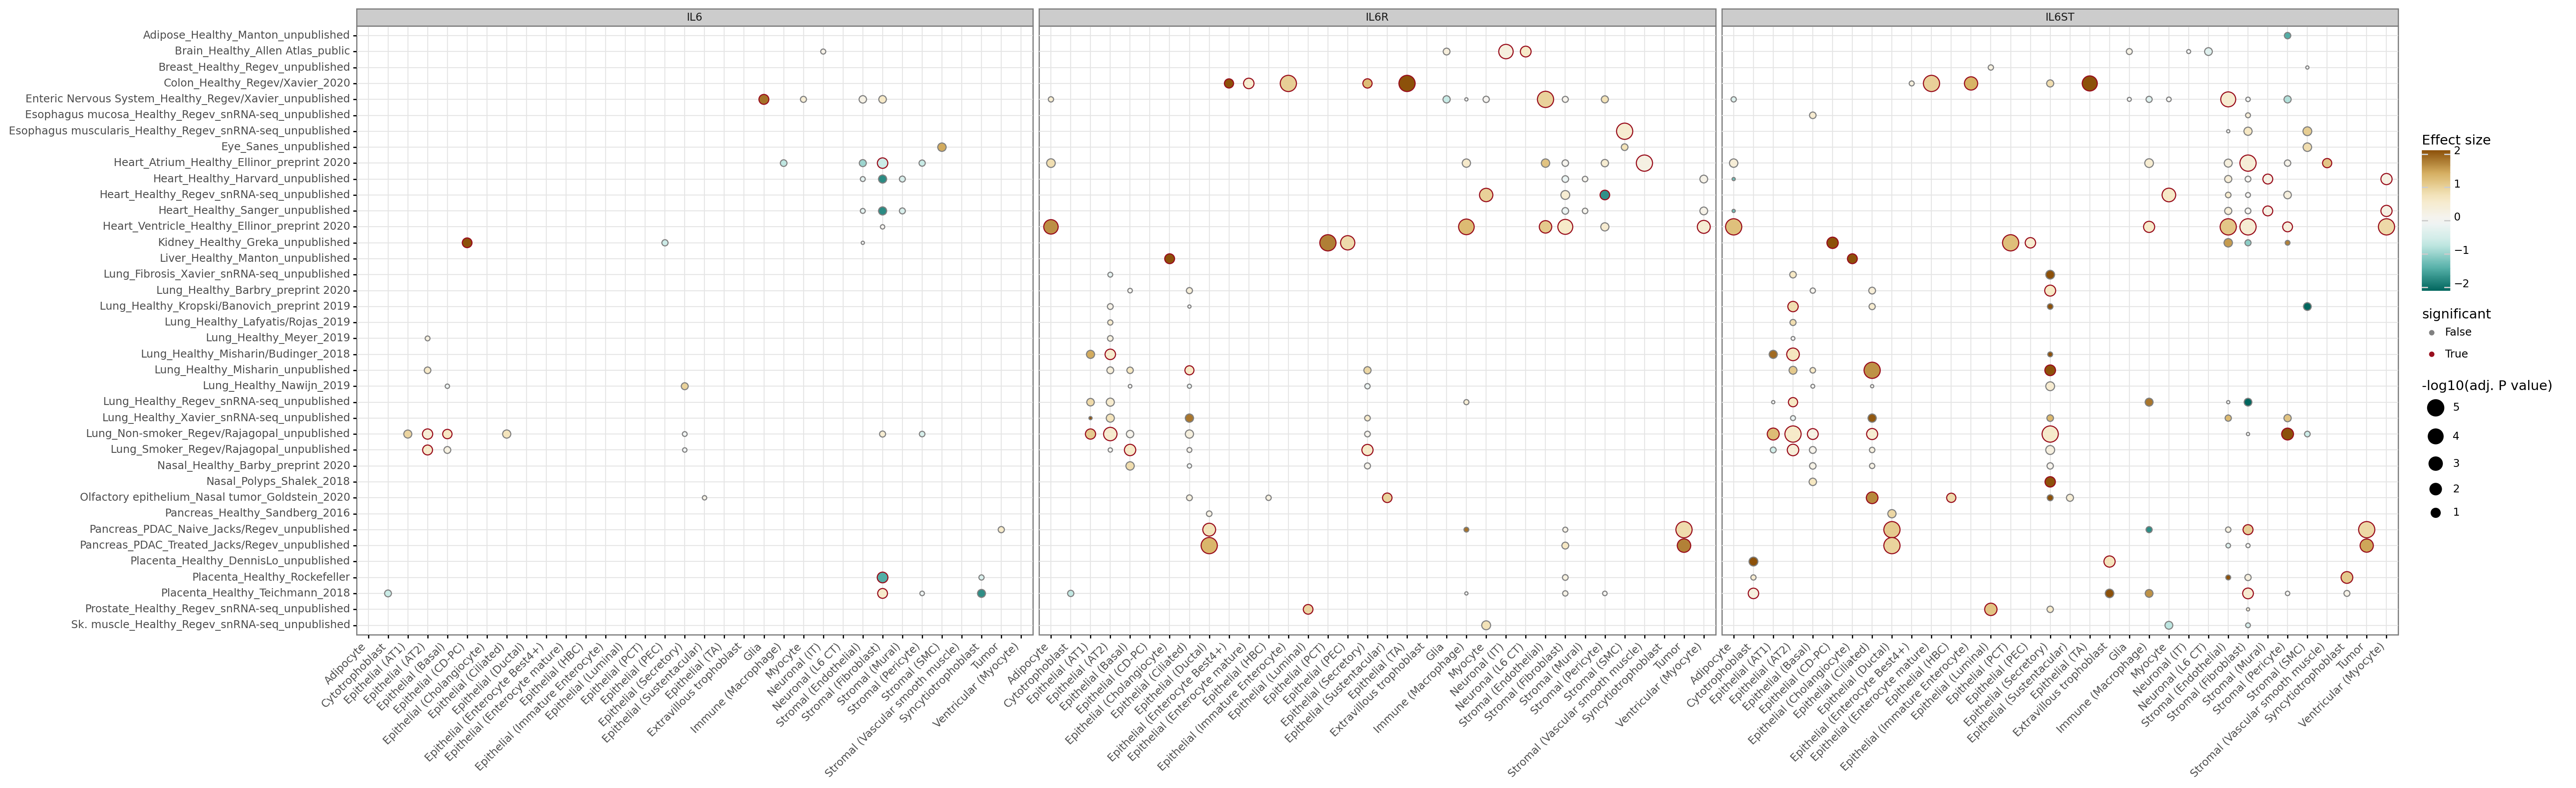

<ggplot: (8728602589094)>


In [32]:
df = results[results.gene.str.startswith('IL6')].copy()

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(df.dataset.unique())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='celltype', y='dataset'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Tissue (dataset)', x='') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,7))+
    facet_wrap('gene', ncol=6)+
    theme(
      axis_title_x = element_blank(),
      axis_title_y = element_blank(),
      figure_size=(30,9),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-IL6.pdf', width=30, height=9, limitsize=False)
print(g)

## MYRF MBP MOG

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 25 x 9 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-myelin-myrfmbpmog.pdf


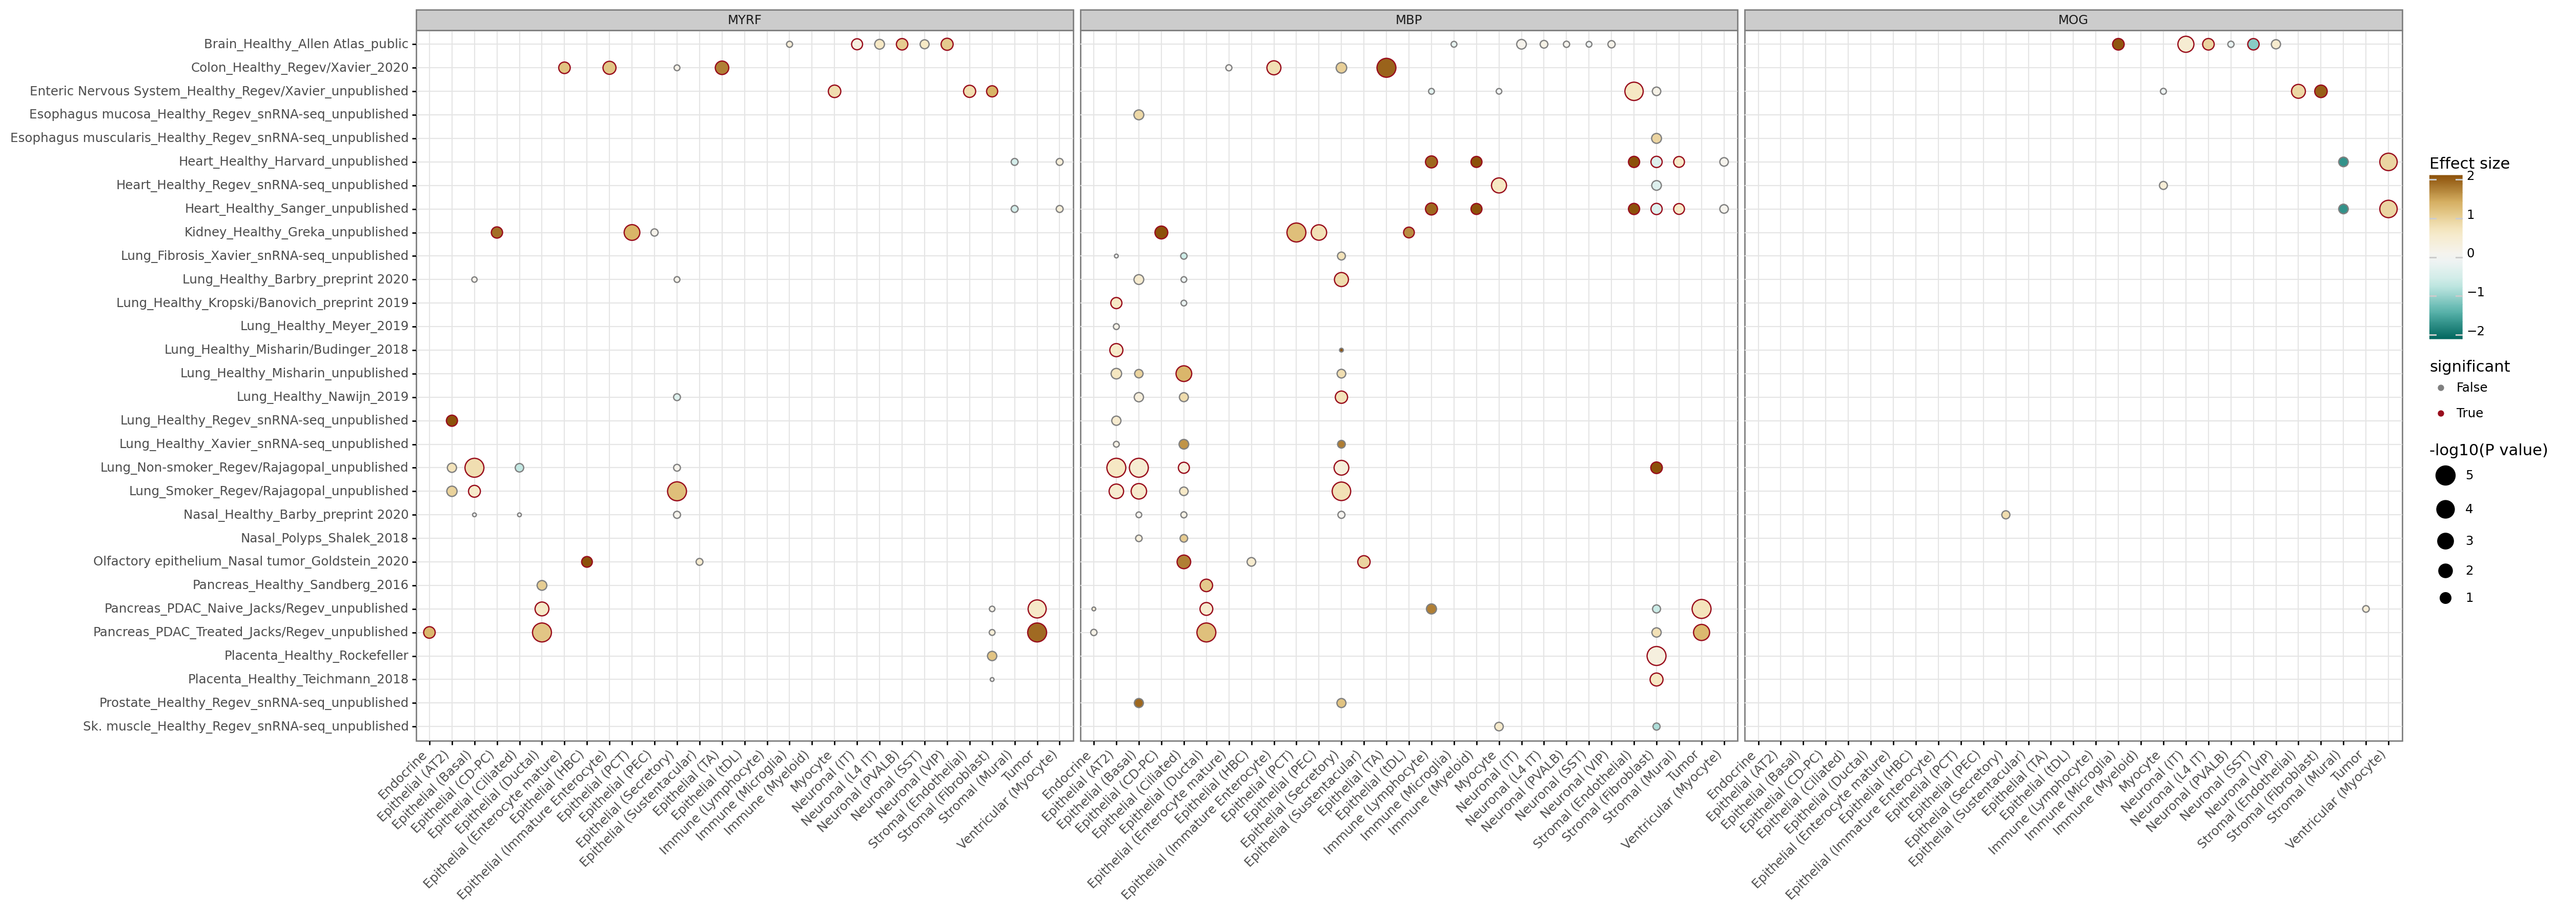

<ggplot: (8728590818521)>


In [33]:
df = results[results.gene.isin(('MYRF', 'MBP', 'MOG'))].copy()
df['gene'] = pd.Categorical(df.gene, categories=('MYRF', 'MBP', 'MOG'))

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(df.dataset.unique())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='celltype', y='dataset'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(P value)", y='Tissue (dataset)', x='') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,7))+
    facet_wrap('gene', ncol=3)+
    theme(
      axis_title_x = element_blank(),
      axis_title_y = element_blank(),
      figure_size=(25,9),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-myelin-myrfmbpmog.pdf', width=25, height=9)
print(g)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 25 x 15 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure-myelin.pdf


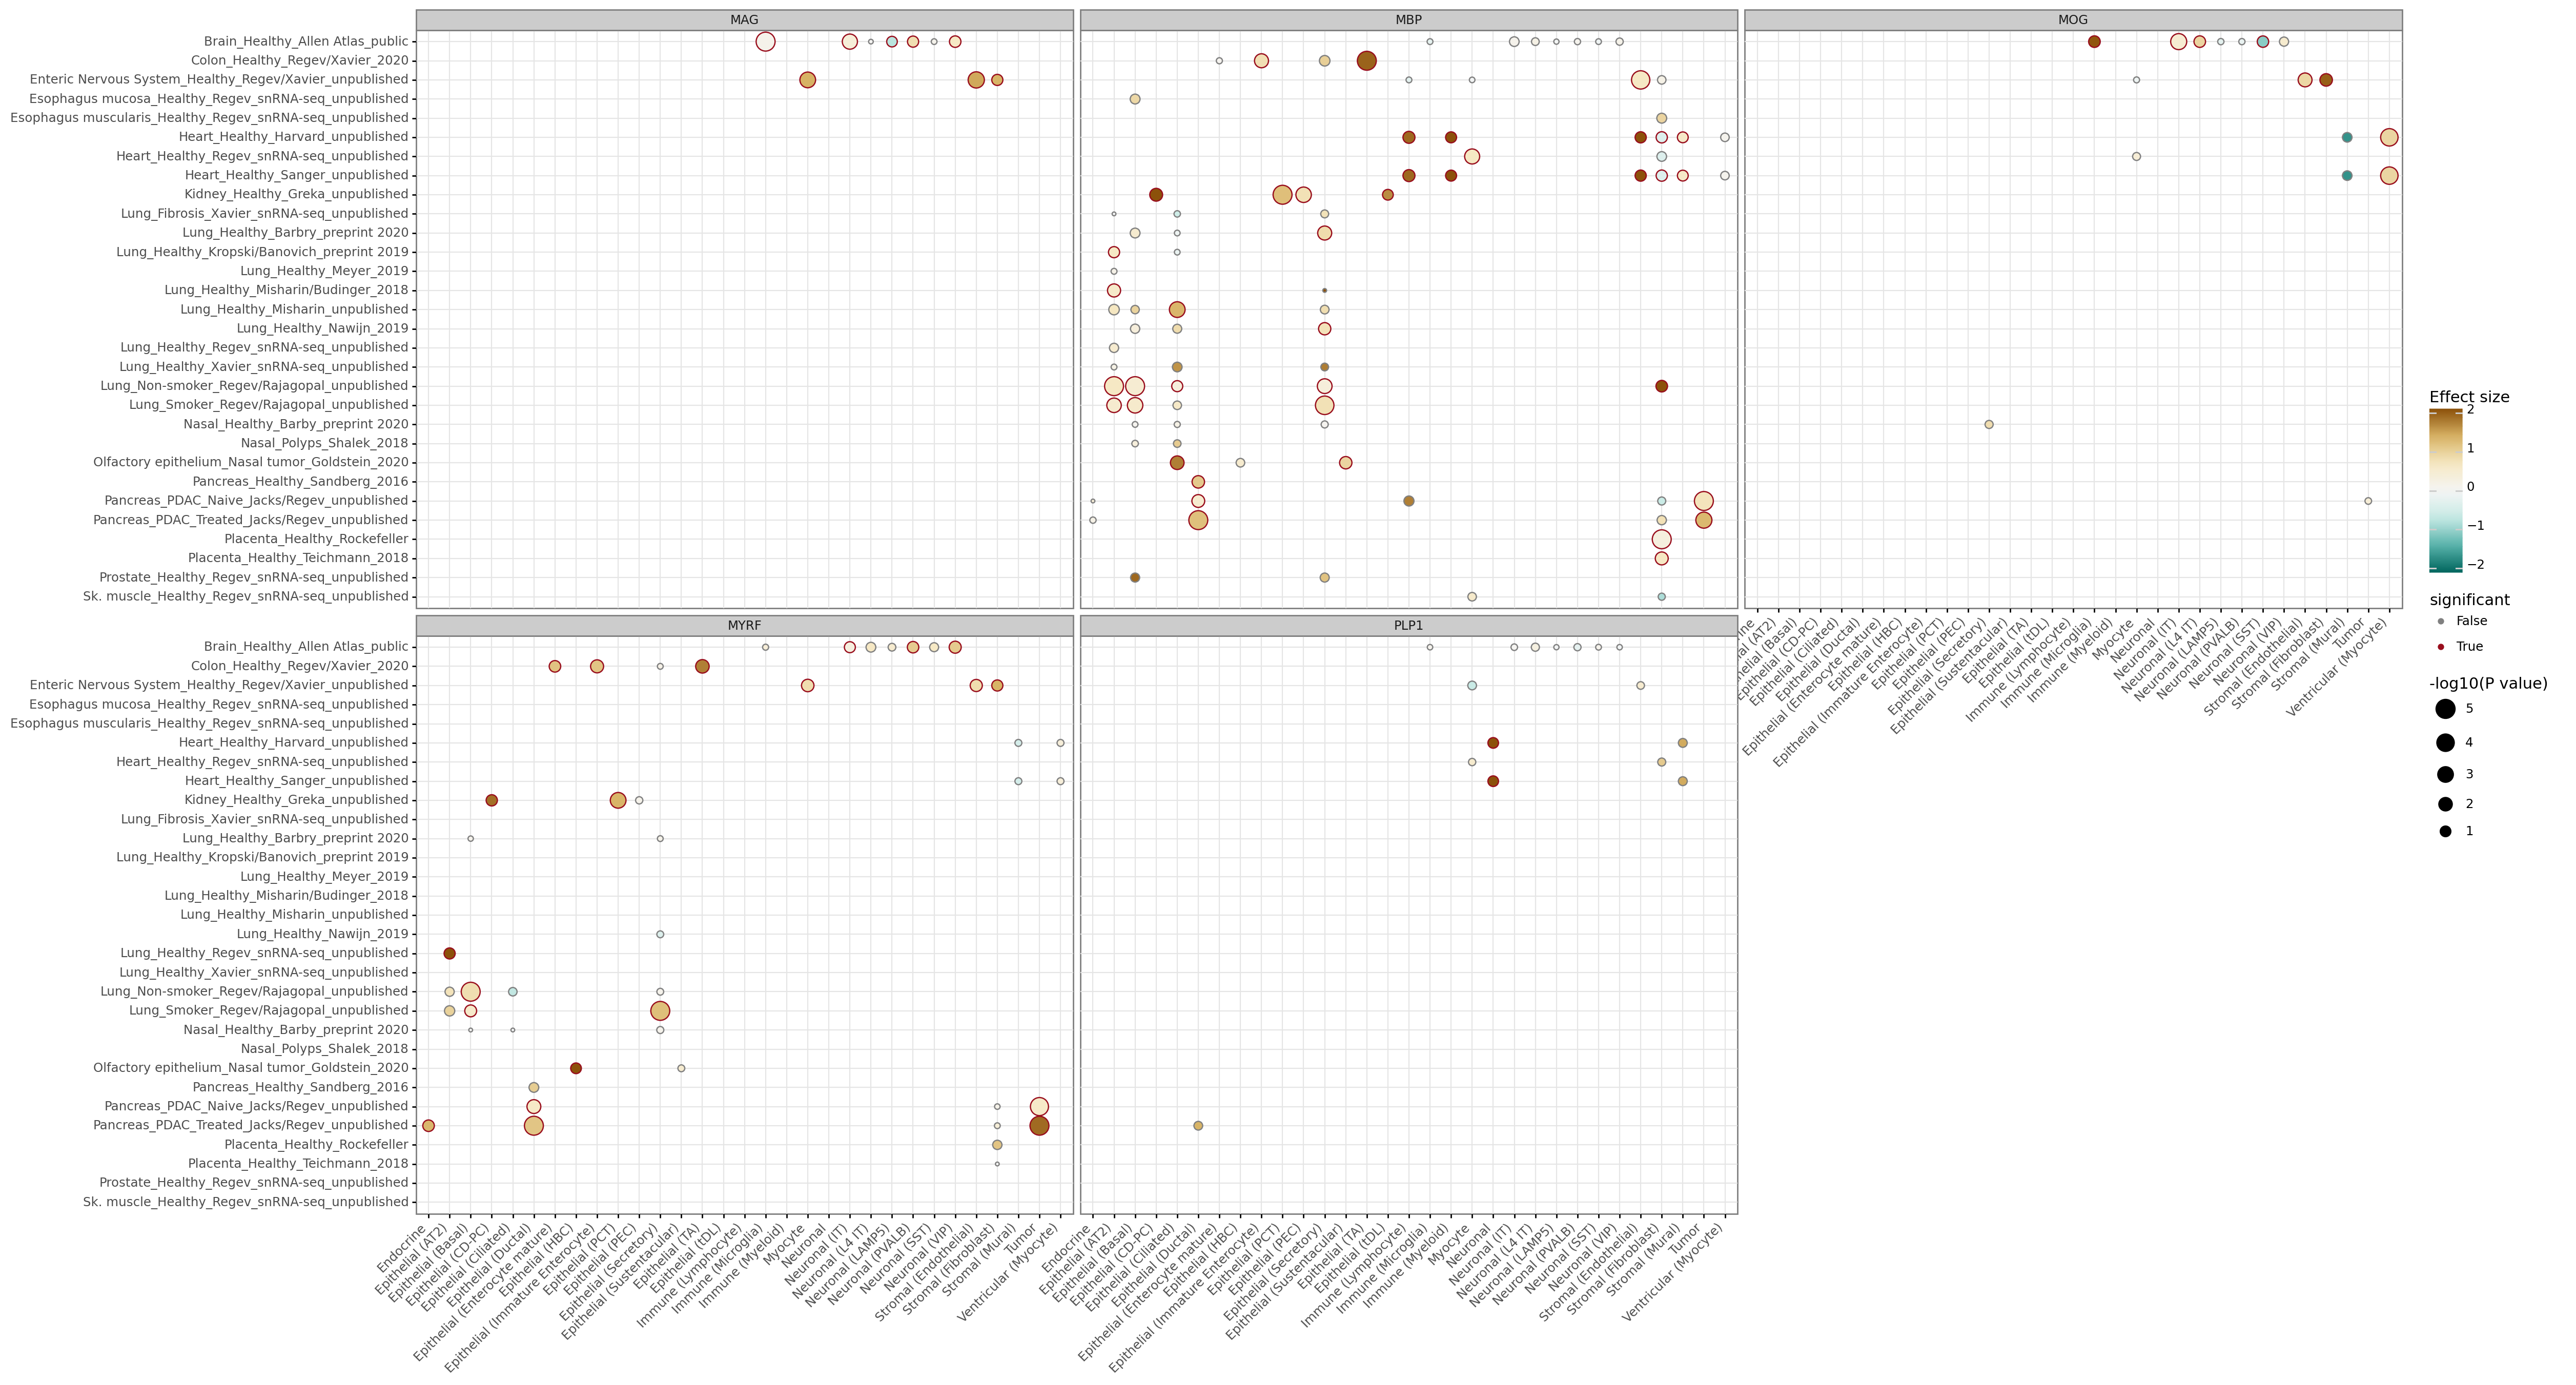

<ggplot: (8728591566873)>


In [34]:
df = results[results.gene.isin(('MAG', 'MOG', 'MBP', 'PLP1', 'MYRF'))].copy()

ct = df.groupby('celltype')['significant'].sum() > 0
ct = ct[ct].index
df = df[df.celltype.isin(ct)]

df.loc[df.Estimate < -2, 'Estimate'] = -2
df.loc[df.Estimate > 2, 'Estimate'] = 2
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

df['dataset'] = pd.Categorical(df.dataset, categories = reversed(sorted(df.dataset.unique())))
limit = max(df.Estimate.abs()) * np.array([-1, 1])


g = (
    ggplot(aes(x='celltype', y='dataset'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
    scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(P value)", y='Tissue (dataset)', x='') +
    guides(size = guide_legend(reverse=True)) +
    theme_bw() +
    scale_size(range = (1,7))+
    facet_wrap('gene', ncol=3)+
    theme(
      axis_title_x = element_blank(),
      axis_title_y = element_blank(),
      figure_size=(25,15),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)

ggsave(g, 'figure-myelin.pdf', width=25, height=15)
print(g)

### Plot each dataset separately

In [ ]:
df_all = results.copy()

for dataset in sorted(df_all.dataset.unique()):

    df = df_all[df_all.dataset == dataset].copy()
    
    ct = df.groupby('celltype')['significant'].sum() > 0
    ct = ct[ct].index
    n_ct = len(ct)
    df = df[df.celltype.isin(ct)]
    if not len(df)>0:
        continue

    df.loc[df.Estimate < -2, 'Estimate'] = -2
    df.loc[df.Estimate > 2, 'Estimate'] = 2
    df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5

    df['gene'] = pd.Categorical(df.gene, categories = reversed(sorted(df.gene.unique())))
    df['celltype'] = pd.Categorical(df.celltype, categories = (sorted(df.celltype.unique())))
    limit = max(df.Estimate.abs()) * np.array([-1, 1])


    g = (
        ggplot(aes(x='celltype', y='gene'), data=df) +
        geom_point(aes(size='neglog_pval_adj', fill='Estimate', color='significant'))+
        scale_fill_distiller(type='div', limits=limit, name='Effect size') + 
        scale_color_manual(values=('#808080', '#990E1D')) + 
        labs(size = "-log10(P value)", y='Tissue (dataset)', x='') +
        guides(size = guide_legend(reverse=True)) +
        theme_bw() +
        scale_size(range = (1,8))+
        facet_wrap('dataset', ncol=1, scales='free')+
        theme(
          axis_title_x = element_blank(),
          axis_title_y = element_blank(),
          figure_size=(n_ct*1.01, 12),
          legend_key=element_blank(),
          axis_text_x = element_text(rotation=45, hjust=1.),
        )
    )
    
    print(g)